In [1]:
from collections import Counter
import pathlib
import json
from datetime import datetime, timedelta, timezone

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# !pip install folium
import folium

from pathlib import Path
from tqdm import tqdm

from concurrent.futures import ThreadPoolExecutor

In [3]:
pd.__version__

'1.5.3'

In [2]:
def load_single_response(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            return file_path.name, json.load(file)
    except Exception as e:
        print(f"Unable to open : {file_path}")
        print(f"Exception is '{e}'")
        return None   

def load_all_responses(folder):
    f_path_list = sorted(
        list(folder.iterdir()), 
#         key=lambda p: datetime.strptime(p.name[-24:-5] , DATETIME_FILENAME_FORMAT)
        key=lambda p: datetime.strptime(p.name[-29:-5] , DATETIME_FILENAME_FORMAT)
    )

    with ThreadPoolExecutor(max_workers=40) as executor:
        return list(
            tqdm(
                executor.map(load_single_response, f_path_list),
                total=len(f_path_list), miniters=int(len(f_path_list) // 10),
                desc=f"Read {str(folder)} to RAM", ascii=True
            )
        )
    
def dict_special_comparator(dict1, dict2, not_compare_keys=['response_datetime']):
    if not isinstance(not_compare_keys, set):
        not_compare_keys = set(not_compare_keys)
    if not (dict1.keys() ^ dict2.keys()).issubset(not_compare_keys):
        return False
    for k in dict1.keys() & dict2.keys() - not_compare_keys:
        if dict1[k] != dict2[k]:
            return False
    return True

In [2]:
DATETIME_FILENAME_FORMAT = '%Y-%m-%d %H;%M;%S%z'

TROJMIASTO_FOLDER_PATH = pathlib.Path("../../data/local/trojmiasto")
TROJMIASTO_REQUESTS_PATH = TROJMIASTO_FOLDER_PATH / "jsons"
TROJMIASTO_TABLES_PATH = TROJMIASTO_FOLDER_PATH / "tables"

In [6]:
resps = load_all_responses(TROJMIASTO_REQUESTS_PATH/("trans_data_17_APR_2023"))
resps_proc = list(map(process_single_response, resps)) 
resps_opt = gef_cleared_df(resps_proc)

Read ..\..\data\local\trojmiasto_2\jsons\trans_data_17_APR_2023 to RAM: 100%|##########| 10503/10503 [00:34<00:00, 306.09it/s]
100%|██████████| 10503/10503 [00:04<00:00, 2321.20it/s]


In [3]:
list(TROJMIASTO_TABLES_PATH.iterdir() ) 

[WindowsPath('../../data/local/trojmiasto/tables/trans_data_14_APR_2023_origin.parquet'),
 WindowsPath('../../data/local/trojmiasto/tables/trans_data_15_APR_2023_origin.parquet'),
 WindowsPath('../../data/local/trojmiasto/tables/trans_data_16_APR_2023_origin.parquet'),
 WindowsPath('../../data/local/trojmiasto/tables/trans_data_17_APR_2023_origin.parquet')]

In [111]:
CHERNIVTSI_FOLDER_PATH = pathlib.Path(f"../../data/local/chernivtsi")
CHERNIVTSI_REQUESTS_PATH = CHERNIVTSI_FOLDER_PATH / "jsons"
CHERNIVTSI_TABLES_PATH = CHERNIVTSI_FOLDER_PATH / "tables"

In [15]:
[p.name for p in (TROJMIASTO_REQUESTS_PATH/'trans_data_18_APR_2023').iterdir() if len(p.name) == 30]

{35}

In [20]:
import os


for folder in list(TROJMIASTO_REQUESTS_PATH.iterdir())[:-1]: 
    files_list = [p for p in folder.iterdir() if len(p.name) == 30]
    for file_path in tqdm(files_list):
        dt_ = datetime.strptime(file_path.name[-24:-5], '%Y-%m-%d %H;%M;%S').replace(tzinfo=timezone(timedelta(hours=3)))
#         .astimezone(timezone.utc)
        new_tm = dt_.astimezone(timezone.utc).strftime('%Y-%m-%d %H;%M;%S%z')
        new_tm_str = dt_.astimezone(timezone.utc).strftime('%Y-%m-%d %H;%M;%S%z')
#         print(f"{dt_}\t->\t{new_tm_str}")
        file_path2 = file_path
        file_path2 = file_path2.with_name(f"trans_{new_tm_str}.json")
#         print(f"\n{file_path}\n\t->\n{file_path2}")
        os.rename(file_path, file_path2)
#         break
#     breakTROJMIASTO_REQUESTS_PATH
    
    

100%|██████████| 14382/14382 [00:14<00:00, 985.41it/s] 


## Analyse data

In [10]:
df_sum = None
for df_path in tqdm(list(Path("../data/local/tables/").iterdir())[-10:]):
    if df_sum is None: 
        df_sum = pd.read_csv(df_path, encoding='utf-8', low_memory=False)
    else : 
        df_sum.append(pd.read_csv(df_path, encoding='utf-8', low_memory=False))

100%|██████████| 10/10 [00:08<00:00,  1.11it/s]


In [15]:
df_sum.duplicated()

0

In [16]:
df_sum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280232 entries, 0 to 280231
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           280232 non-null  int64  
 1   imei         280232 non-null  int64  
 2   name         280232 non-null  object 
 3   stateCode    280232 non-null  object 
 4   stateName    280232 non-null  object 
 5   lat          280232 non-null  float64
 6   lng          280232 non-null  float64
 7   speed        280232 non-null  float64
 8   orientation  280232 non-null  float64
 9   gpstime      280232 non-null  object 
 10  routeId      280232 non-null  int64  
 11  routeName    280232 non-null  object 
 12  routeColour  280232 non-null  object 
 13  inDepo       280232 non-null  bool   
 14  busNumber    280232 non-null  object 
 15  perevId      280232 non-null  int64  
 16  perevName    280232 non-null  object 
 17  remark       280232 non-null  object 
 18  online       280232 non-

In [28]:
# df_sum['stateName']

0         used
1         used
2         used
3         used
4         used
          ... 
280227    used
280228    used
280229    used
280230    used
280231    used
Name: stateName, Length: 280232, dtype: object

In [61]:
# df_sum[['routeId', 'routeName', 'routeColour']].value_counts()
# df_sum[['imei', 'name', 'busNumber', 'perevId']].value_counts()
df_sum[['idBusTypes']].value_counts()

idBusTypes
1             200704
2              79528
dtype: int64

In [63]:
df_sum[['imei', 'name', 'busNumber', 'perevId', 'idBusTypes']].value_counts()

imei             name  busNumber  perevId  idBusTypes
355227045371655  A1    6513       7        1             5521
355227046638821  A211  1181       13       1             5328
355228042084283  A207  1032       13       1             5239
355227045540192  A91   7762       1        1             4498
355227044854750  A22   7665       1        1             4483
                                                         ... 
355228043199080  H103  8716       12       1               18
355227045539491  Am86  1027       2        1               10
355228043162351  H107  9138       12       1                5
355227045600855  A142  377        6        2                2
355227046447371  H65   355        6        2                1
Length: 98, dtype: int64

In [42]:
a = df_sum[['remark']].value_counts()

In [57]:
df_sum[df_sum['imei'] == 355227045541257][['imei', 'name', 'busNumber', 'remark']].value_counts()


imei             name  busNumber  remark    
355227045541257  A57   9043       0325 DNSNK    2007
                                  9043 DNSNK    1870
dtype: int64

In [53]:
from collections import Counter

In [58]:
# Counter([k[0] for k in a.to_dict()])

In [59]:
# a.to_dict()

0   id           280232 non-null  int64  

### USELESS ?!
 3   stateCode    280232 non-null  object #only value is 'used'
 4   stateName    280232 non-null  object #only value is 'used'
 18  online       280232 non-null  bool   #only value is 'True'

### ROUTES
 10  routeId      280232 non-null  int64  
 11  routeName    280232 non-null  object 
 12  routeColour  280232 non-null  object 
    

### OWNER
 15  perevId      280232 non-null  int64  
 16  perevName    280232 non-null  object 


### WEEHCLE 
 1   imei         280232 non-null  int64  
 2   name         280232 non-null  object 
 14  busNumber    280232 non-null  object 
 17  remark       280232 non-null  object 
 19  idBusTypes   280232 non-null  int64  

### GPS
 5   lat          280232 non-null  float64
 6   lng          280232 non-null  float64
 7   speed        280232 non-null  float64
 8   orientation  280232 non-null  float64
 9   gpstime      280232 non-null  object 
13  inDepo       280232 non-null  bool   


## CODE 
```
Table rowdata.gpsdata {
id int [pk, increment]
lat float
lng float
speed float
orientation float
gpstime datetime
inDepo bool

routeId int [ref: > E.id]

response_datetime datetime

edited datetime

Indexes {
(id) [pk]
}
}

Table rowdata.vehicle as E {
id int [pk, increment]
imei int
name varchar
busNumber int
remark varchar

perevId int [ref: > O.id]
routeId int [ref: > R.id]

edited datetime

Indexes {
(id) [pk]
}
}

Table rowdata.owner as O {
id int [pk, increment]
perevName varchar
edited datetime

Indexes {
(id) [pk]
}
}

Table rowdata.route as R {
id int [pk, increment]
routeName varchar
routeColour varchar

etited datetime

Indexes {
(id) [pk]
}
}
```

In [2]:
DATEBASE_NAME = '17_SEP_2022'

In [184]:
sum_df = pd.read_csv(f"tables/data_for_{DATEBASE_NAME}.csv", encoding='utf-8', low_memory=False)

In [167]:
# sum_df.groupby('imei').size().reset_index(name='count').sort_values(['count'], ascending=False)

In [185]:
sum_df['imei'].value_counts()

355228042084283    5023
355227046504098    4643
355227046450904    4348
355227046451530    4192
355227046451407    4178
                   ... 
355227046638821      35
355228043199098      30
355228043162195      22
355227045598570      18
355227046451688       7
Name: imei, Length: 84, dtype: int64

In [173]:
sum_df[sum_df['imei'] == 355228042084283]

,id,imei,name,stateCode,stateName,lat,lng,speed,orientation,gpstime,routeId,routeName,routeColour,inDepo,busNumber,perevId,perevName,remark,online,idBusTypes
43,294,355228042084283,A207,used,used,48.275355,25.924983,0.0,0.00,2022-09-16 23:04:48,42,39,coral,False,1032,13,Олег Валентинович 39 марш,1032 DNSNK,True,1
66,294,355228042084283,A207,used,used,48.275355,25.924983,0.0,0.00,2022-09-16 23:08:27,42,39,coral,False,1032,13,Олег Валентинович 39 марш,1032 DNSNK,True,1
74,294,355228042084283,A207,used,used,48.275355,25.924983,0.0,0.00,2022-09-16 23:09:44,42,39,coral,False,1032,13,Олег Валентинович 39 марш,1032 DNSNK,True,1
91,294,355228042084283,A207,used,used,48.275355,25.924983,0.0,0.00,2022-09-16 23:14:51,42,39,coral,False,1032,13,Олег Валентинович 39 марш,1032 DNSNK,True,1
104,294,355228042084283,A207,used,used,48.275355,25.924983,0.0,0.00,2022-09-16 23:18:29,42,39,coral,False,1032,13,Олег Валентинович 39 марш,1032 DNSNK,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200520,294,355228042084283,A207,used,used,48.267842,25.935443,17.4,280.04,2022-09-17 11:51:18,42,39,coral,False,1032,13,Олег Валентинович 39 марш,1032 DNSNK,True,1
200628,294,355228042084283,A207,used,used,48.282952,25.953330,0.5,0.00,2022-09-17 14:20:01,42,39,coral,False,1032,13,Олег Валентинович 39 марш,1032 DNSNK,True,1
200685,294,355228042084283,A207,used,used,48.295083,25.940105,0.4,0.00,2022-09-17 17:58:25,42,39,coral,False,1032,13,Олег Валентинович 39 марш,1032 DNSNK,True,1
200706,294,355228042084283,A207,used,used,48.295107,25.940097,0.2,0.00,2022-09-17 18:00:56,42,39,coral,False,1032,13,Олег Валентинович 39 марш,1032 DNSNK,True,1


In [3]:
file_path_list = list(Path("D:/projects/pet_project/tables").iterdir())
file_path_list = sorted(file_path_list,
                        key=lambda p: datetime.strptime(p.name[9:-4], '%d_%b_%Y'))

In [4]:
sum_df = pd.read_csv(file_path_list[10], encoding='utf-8', low_memory=False)

'19'(5287)
Max update time 1924


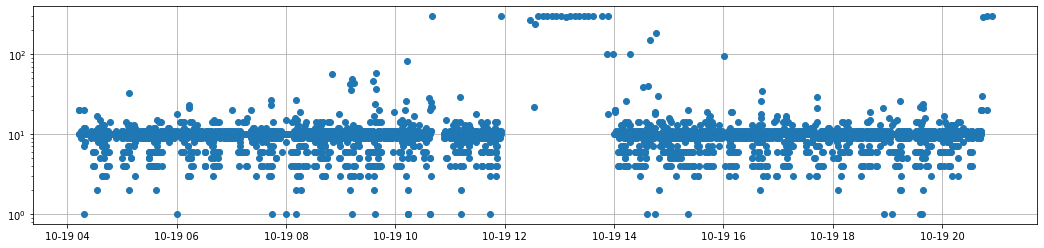

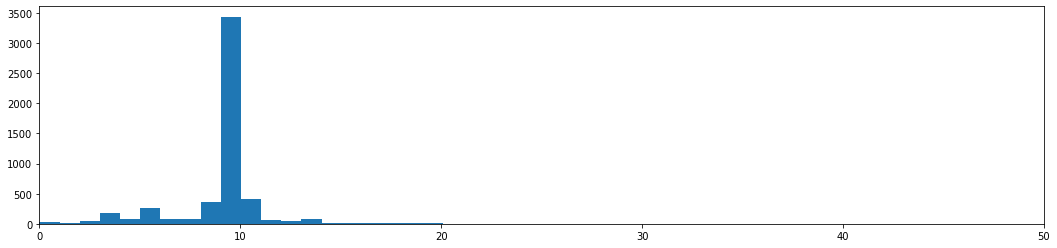

'39'(4836)
Max update time 1966


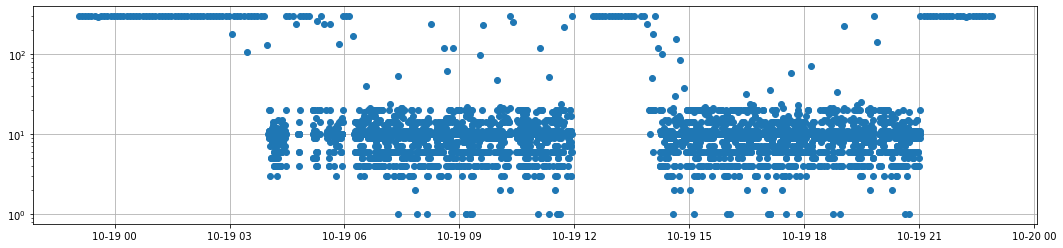

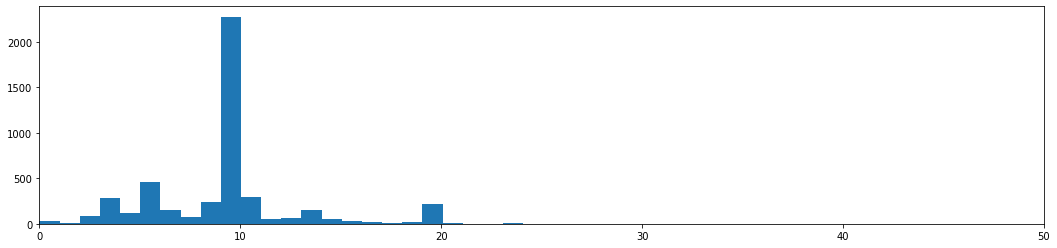

'8T'(4392)
Max update time 2037


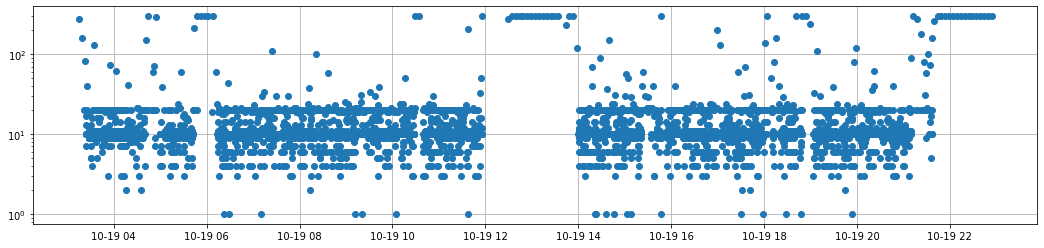

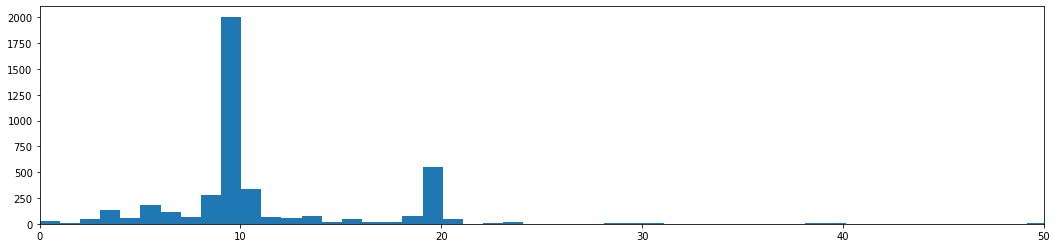

'39'(4121) -> '9A'(200)
Max update time 1925


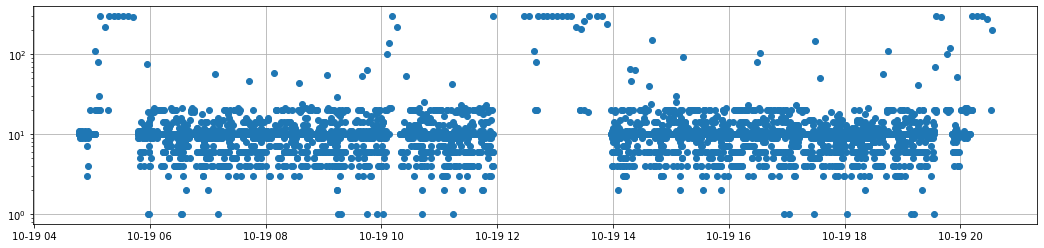

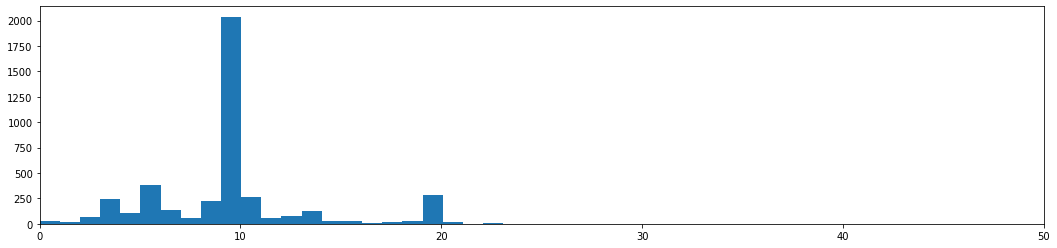

'34'(4245)
Max update time 2055


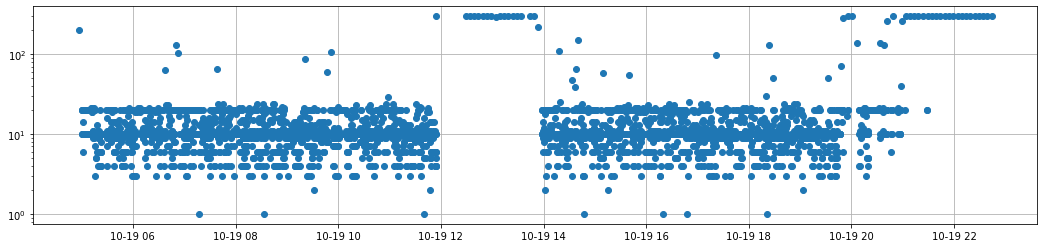

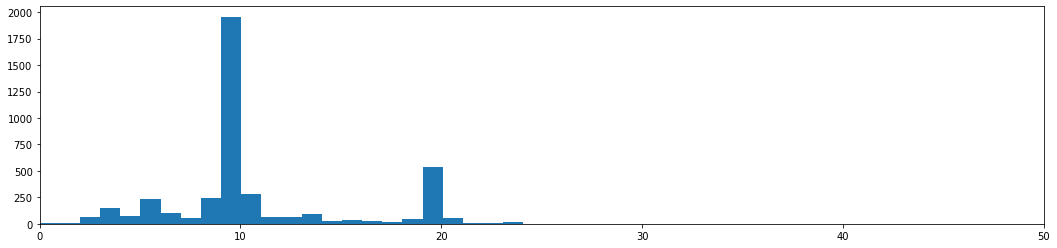

'3/3a'(3518) -> 'T'(629)
Max update time 2050


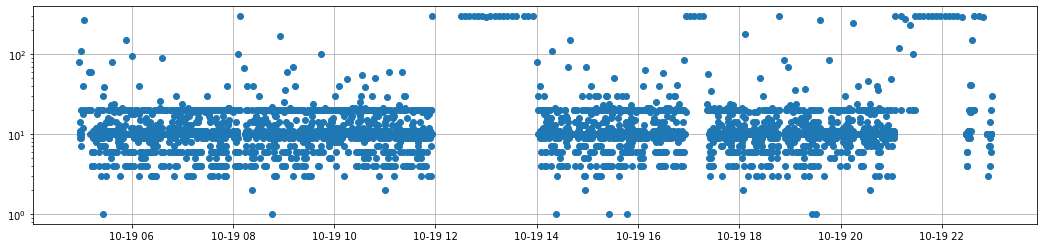

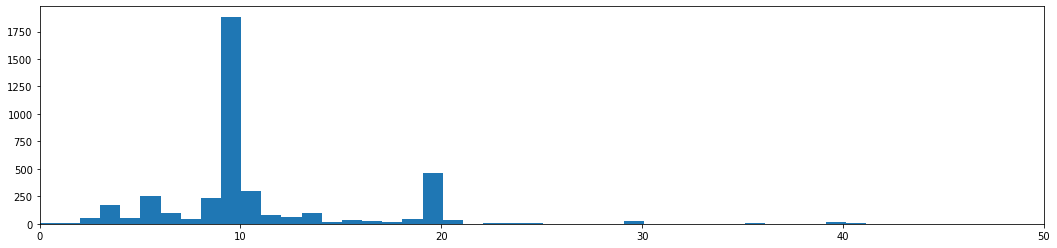

'25'(3919) -> '1'(204)
Max update time 2263


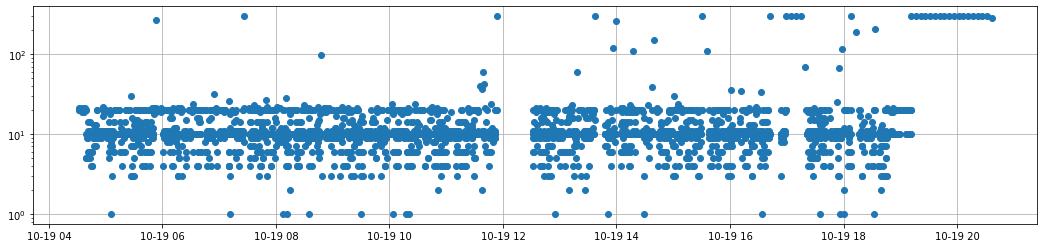

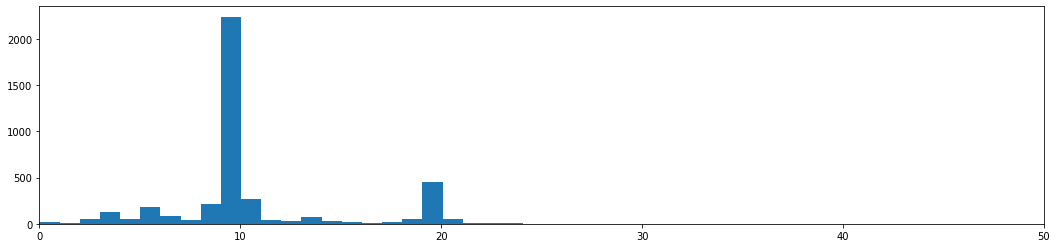

'6'(4083) -> 'A'(1)
Max update time 1850


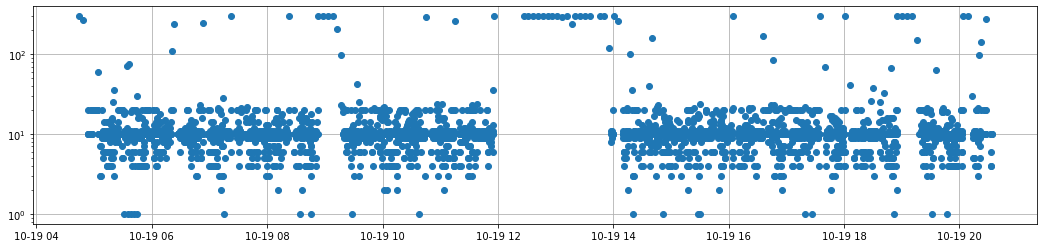

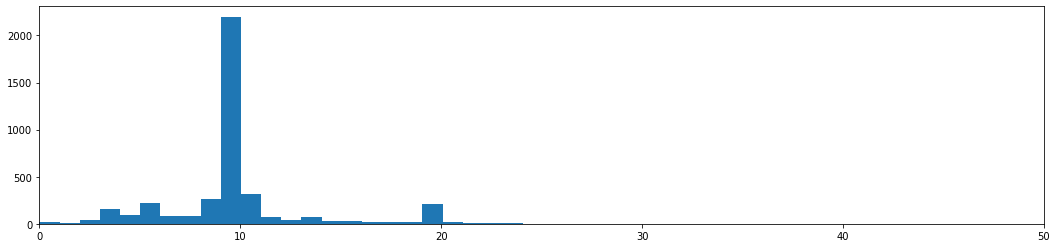

'38'(4075)
Max update time 1957


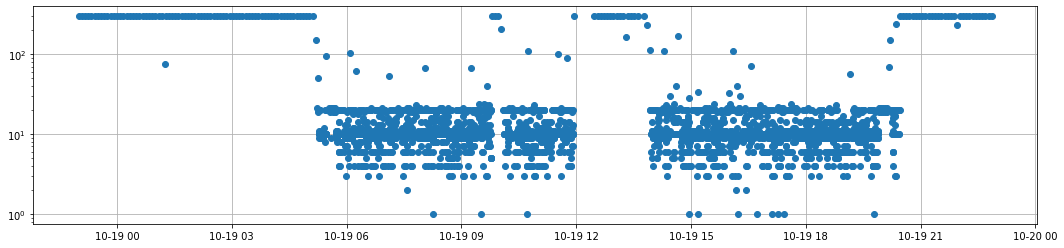

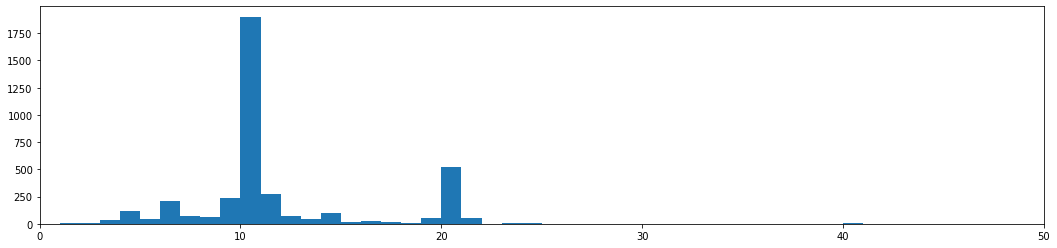

'39'(3579) -> '9'(488)
Max update time 2022


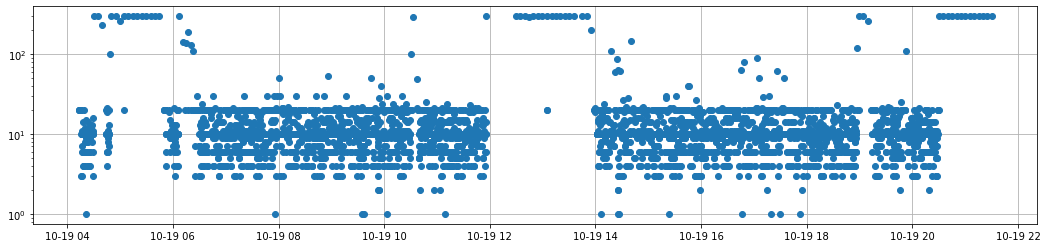

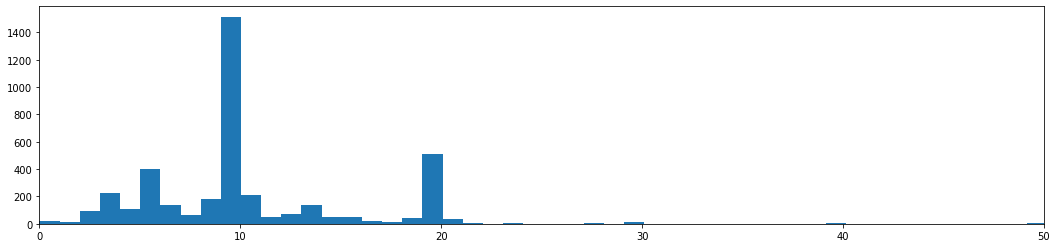

'13'(4062)
Max update time 3234


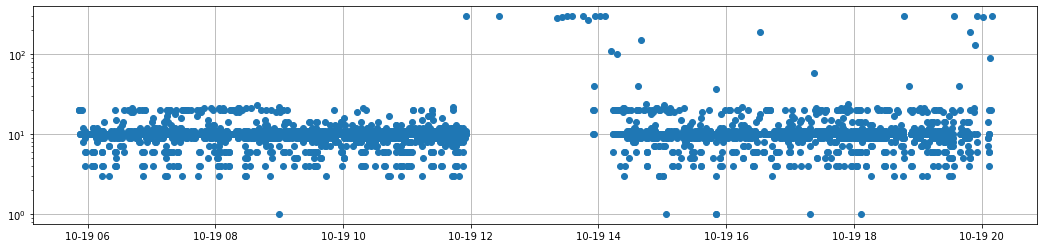

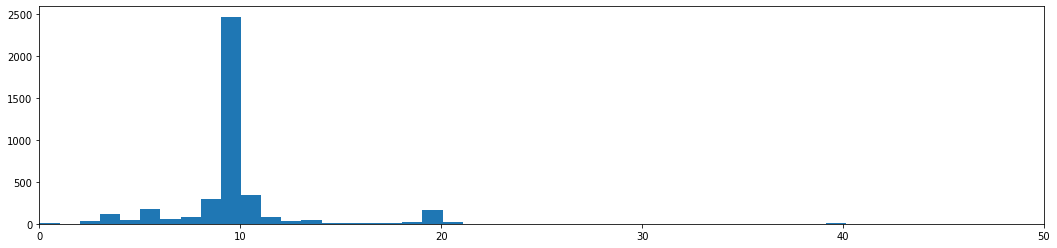

'20'(3766) -> '2'(292)
Max update time 1991


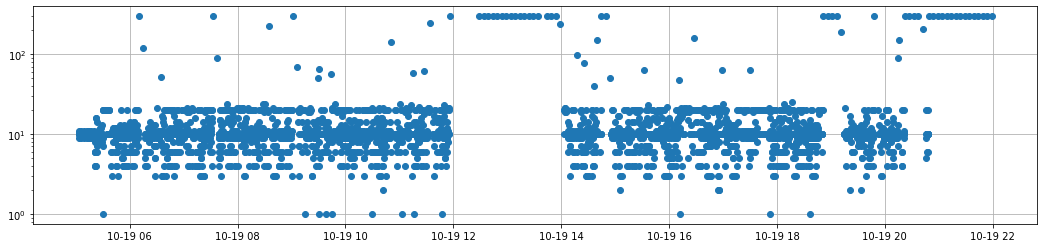

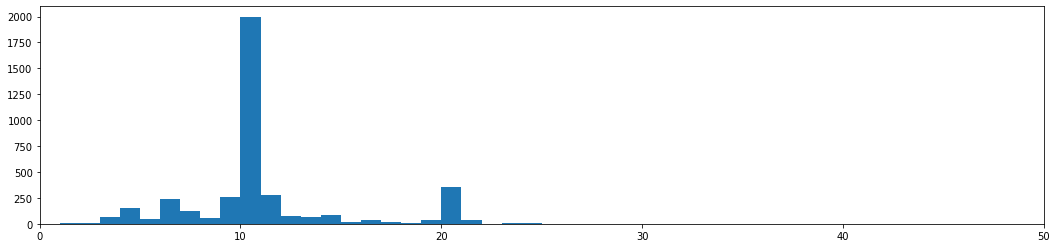

'5T'(3415) -> 'T'(636)
Max update time 2117


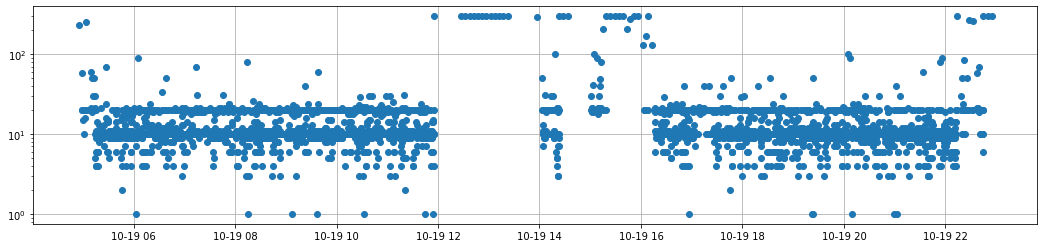

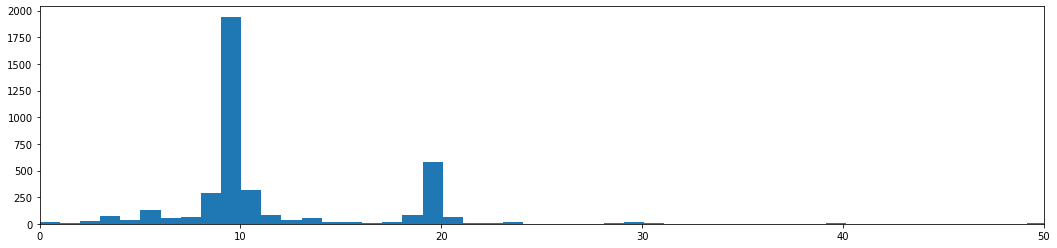

'8T'(3598) -> 'T'(353)
Max update time 1842


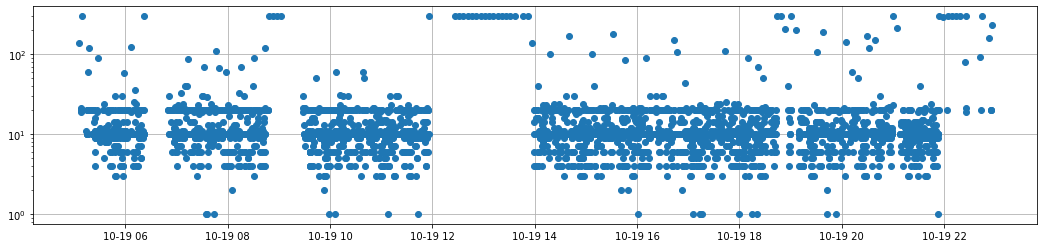

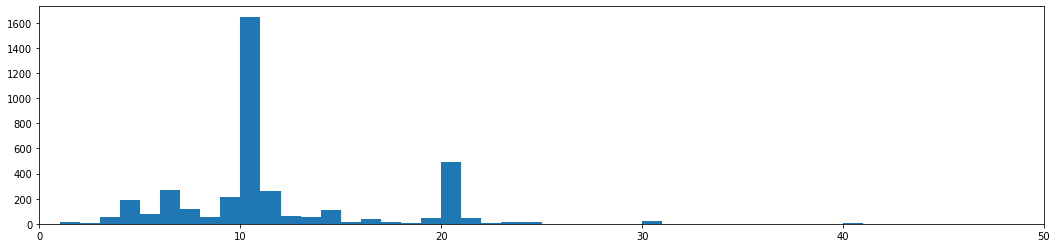

'20'(3567) -> '2'(369)
Max update time 2236


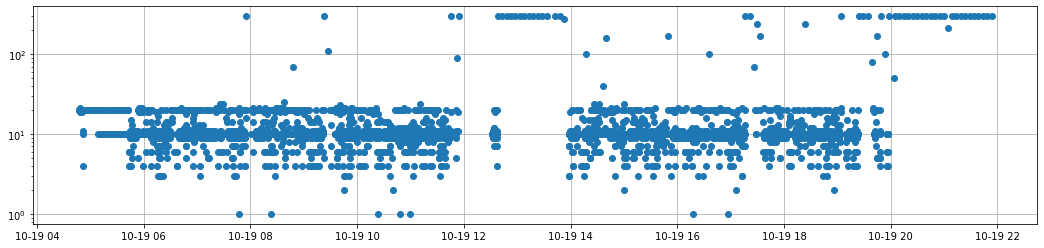

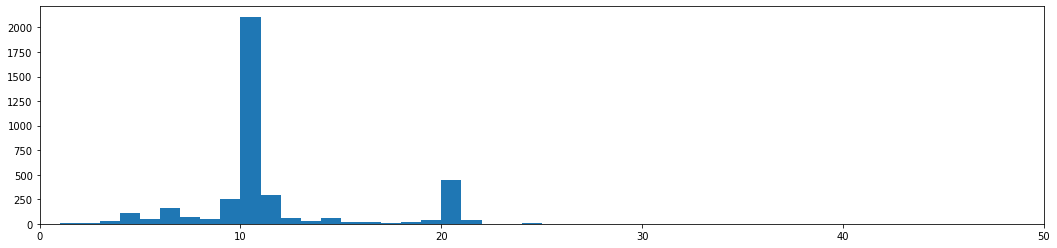

'13'(3897)
Max update time 1988


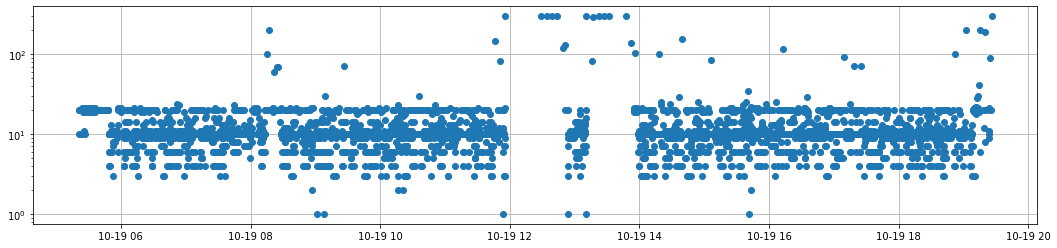

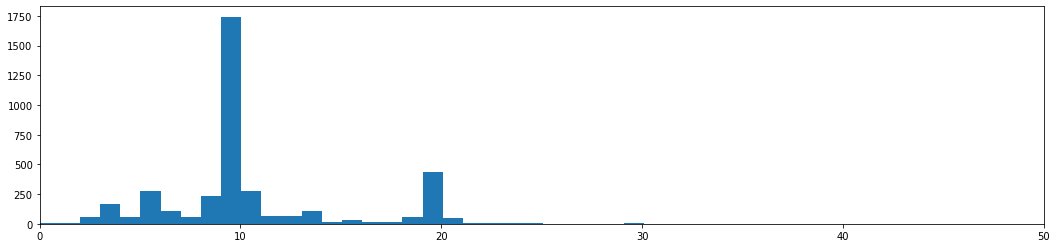

'1'(3856)
Max update time 3544


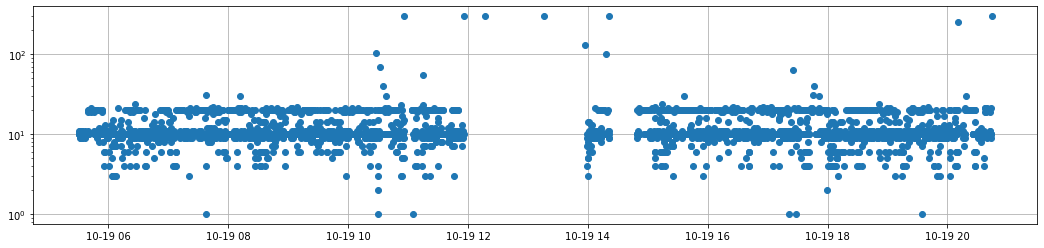

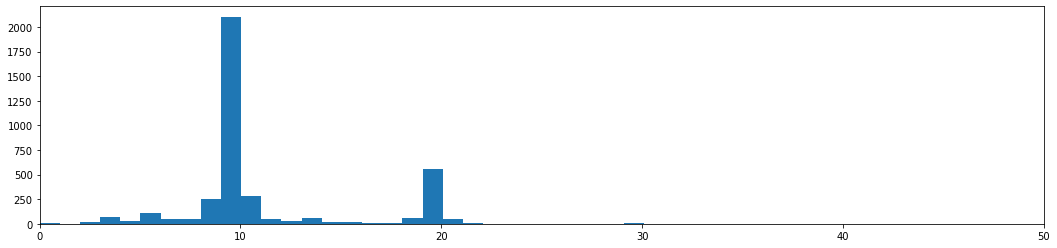

'9A'(3856)
Max update time 2071


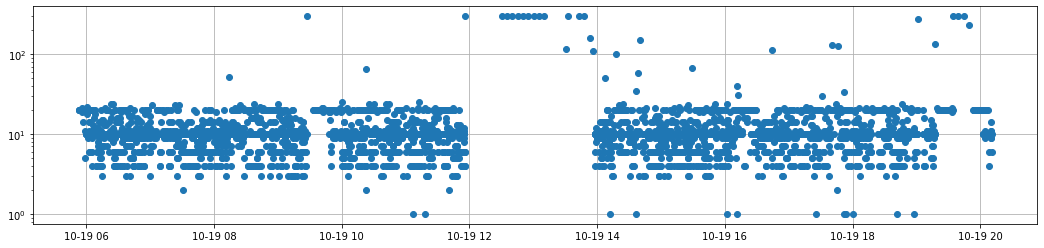

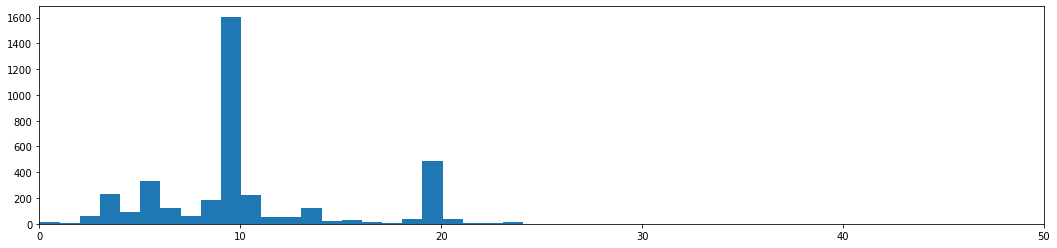

'13'(3841)
Max update time 2131


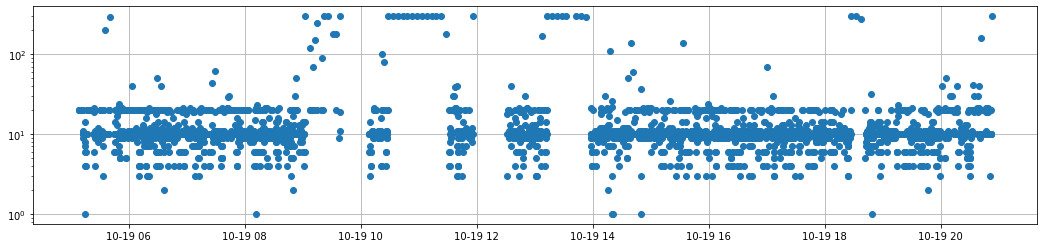

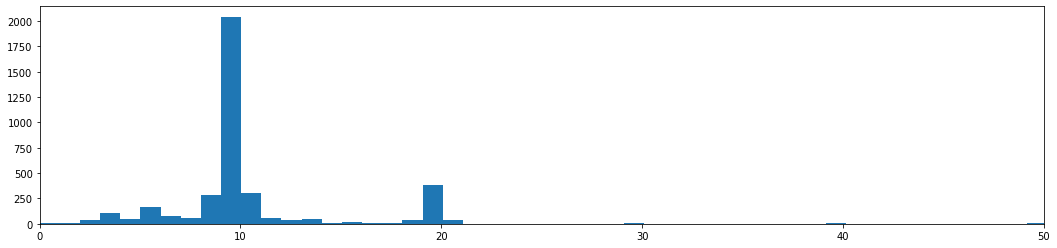

'6'(3808)
Max update time 6361


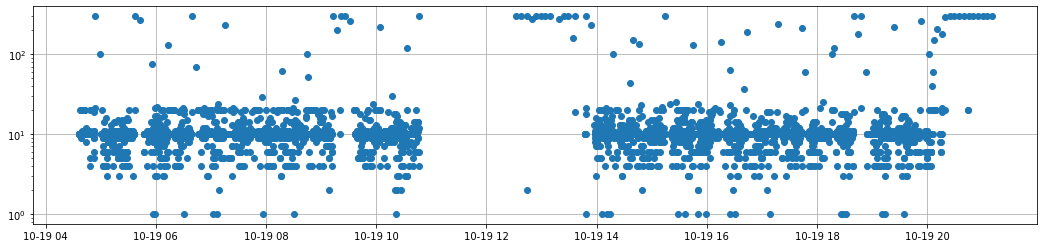

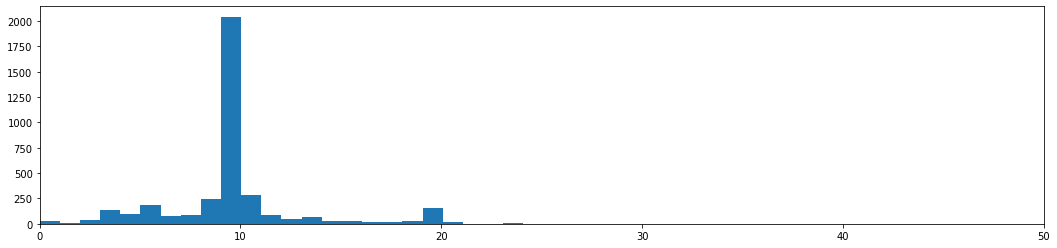

'5T'(3331) -> 'T'(472)
Max update time 2042


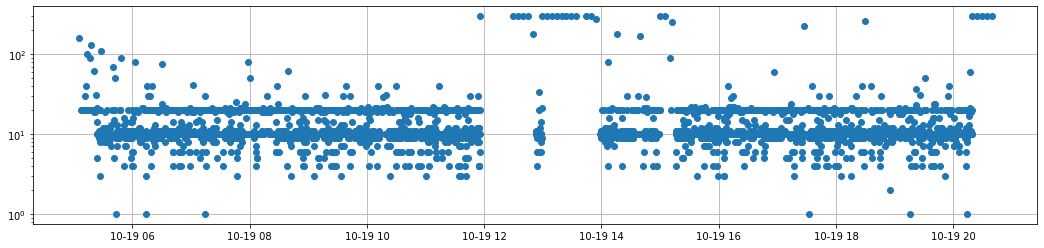

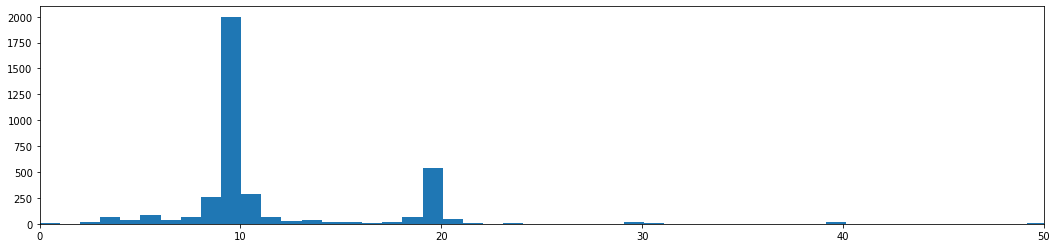

'9A'(3765)
Max update time 1939


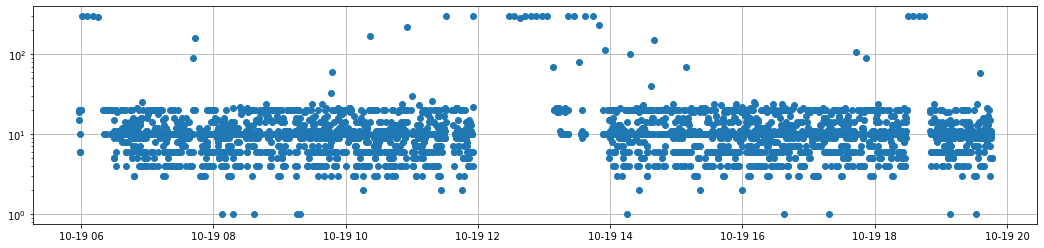

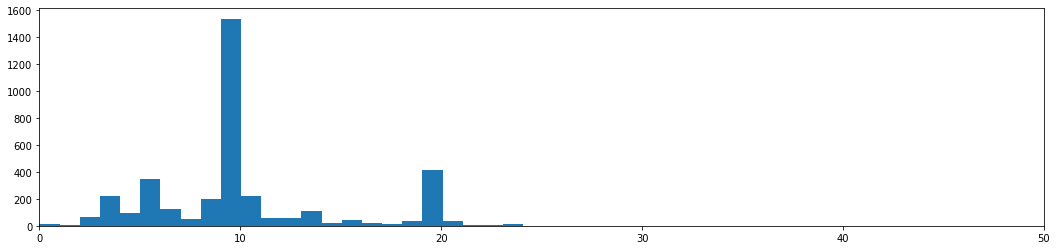

'8T'(3281) -> 'T'(473)
Max update time 2127


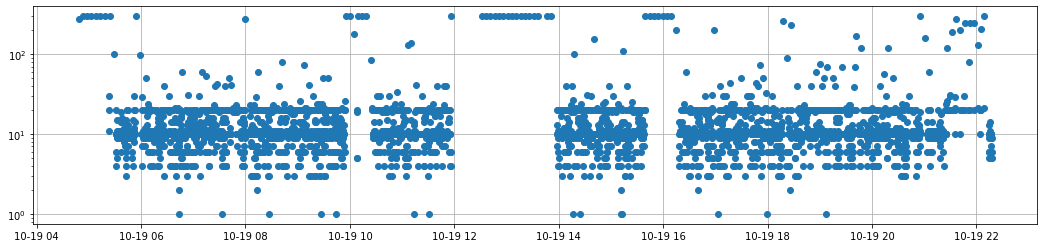

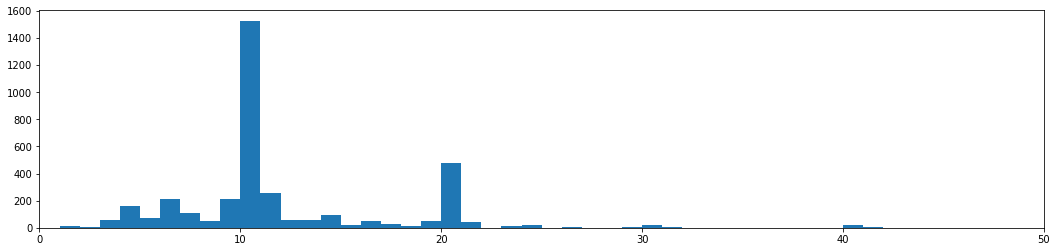

'20'(3395) -> '2A'(335)
Max update time 2524


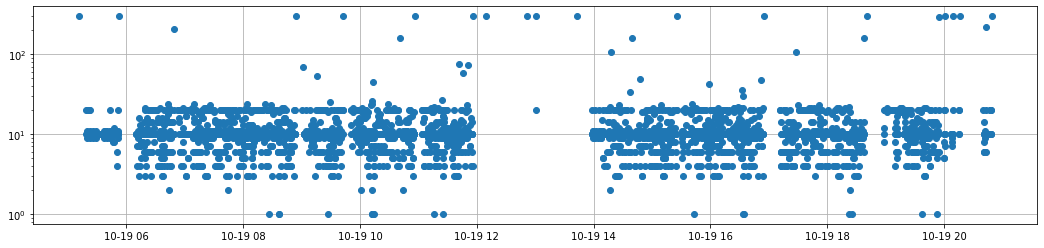

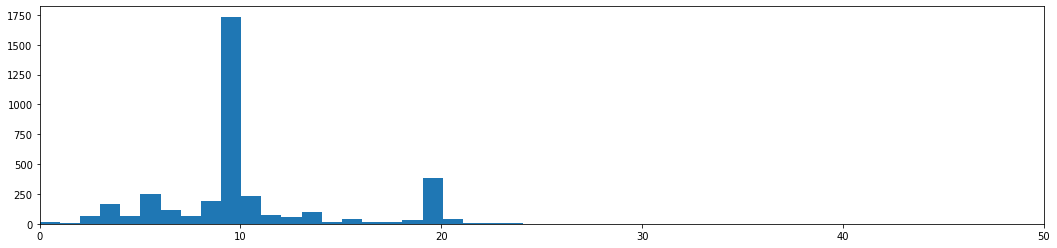

'39'(3405) -> '9'(294)
Max update time 1958


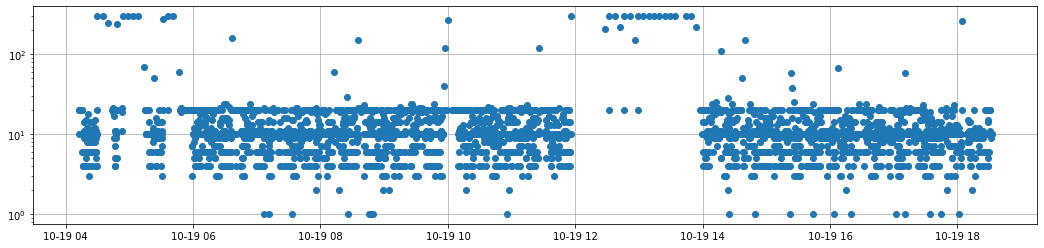

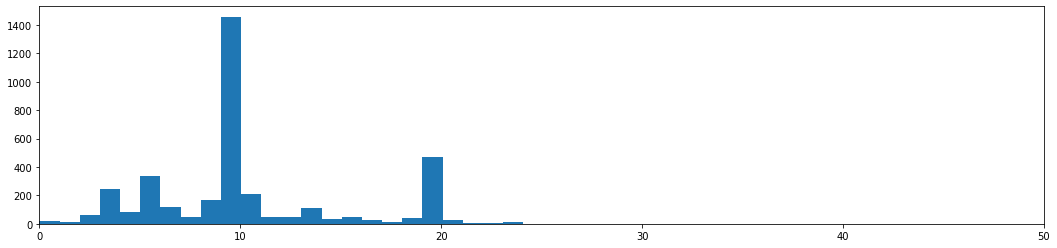

'6/6a'(3168) -> 'T'(506)
Max update time 2117


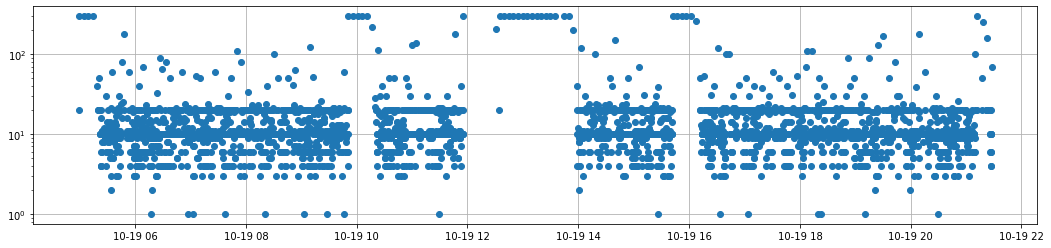

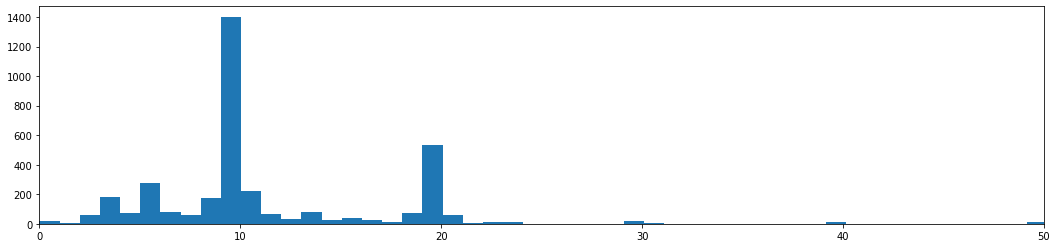

'12'(3644)
Max update time 1986


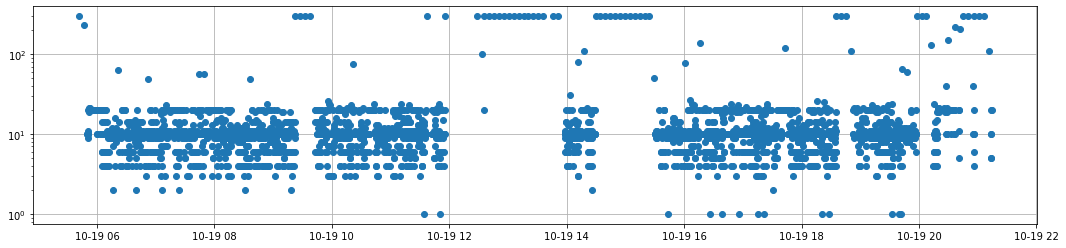

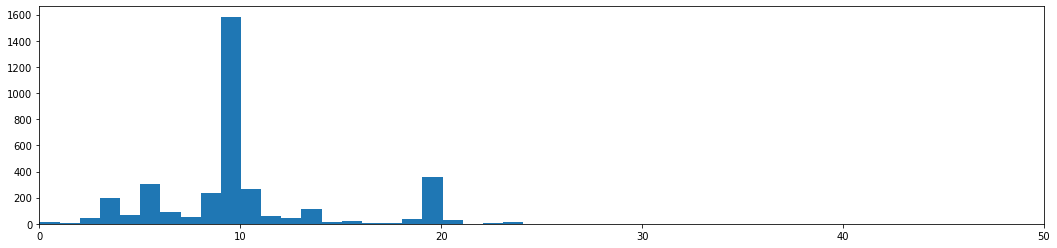

'11'(3620)
Max update time 2919


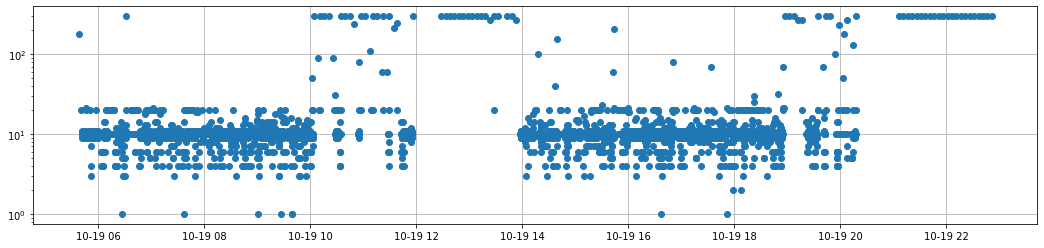

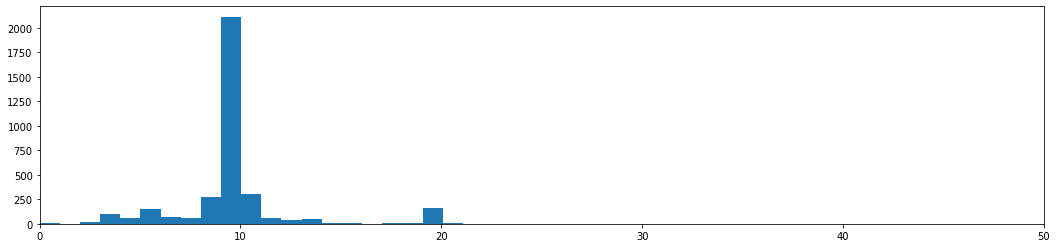

'1'(3592)
Max update time 1982


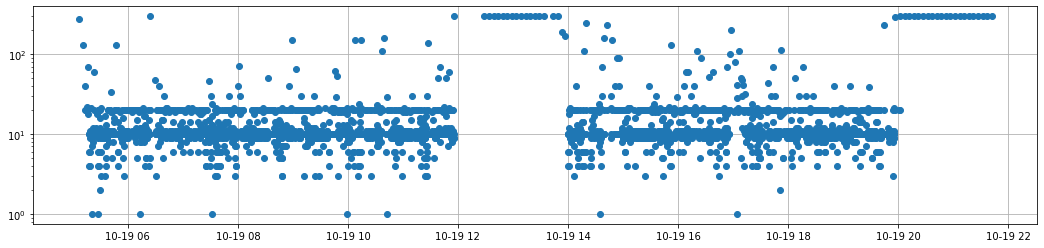

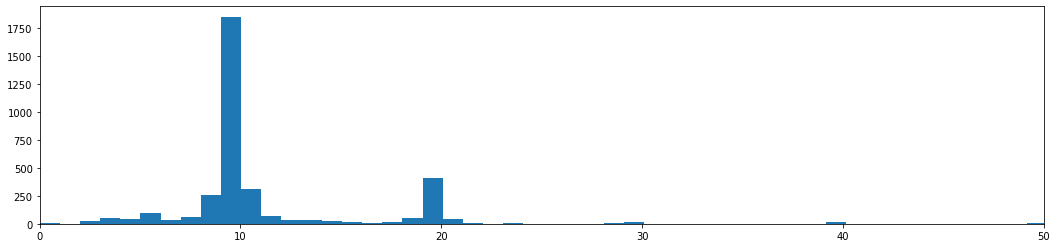

'11'(3571)
Max update time 2062


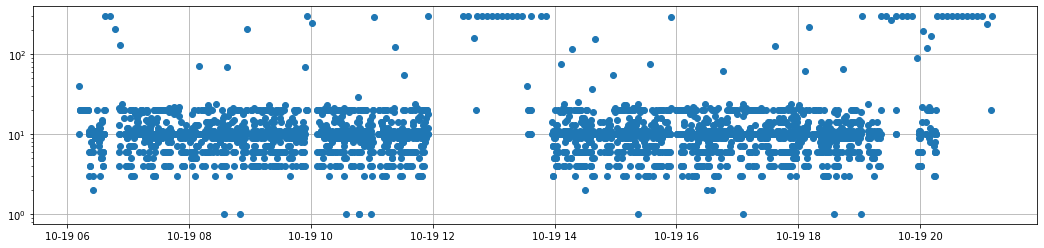

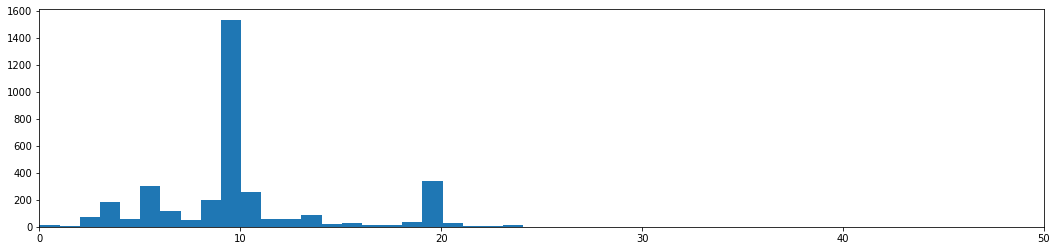

'6/6a'(3052) -> 'T'(508)
Max update time 1954


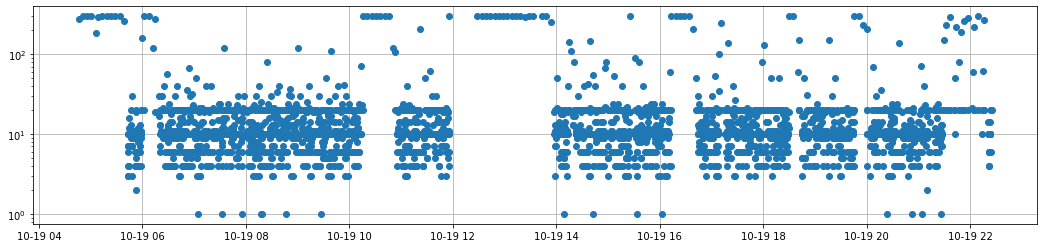

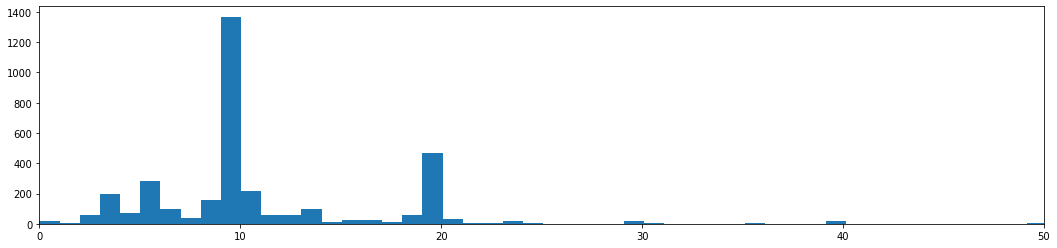

'8T'(3513)
Max update time 1997


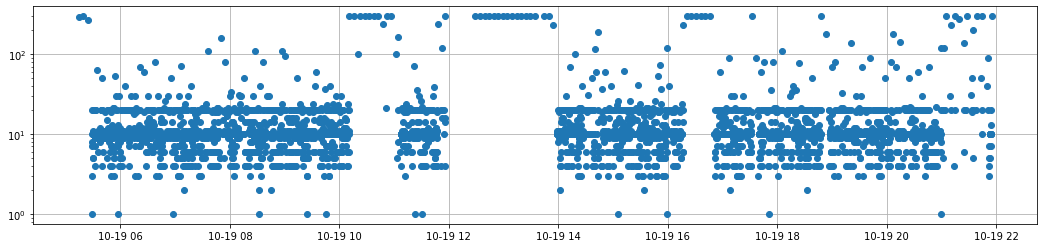

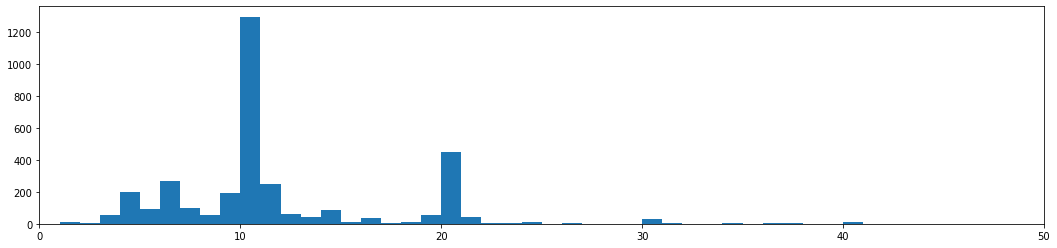

'20'(3103) -> '2'(407)
Max update time 2134


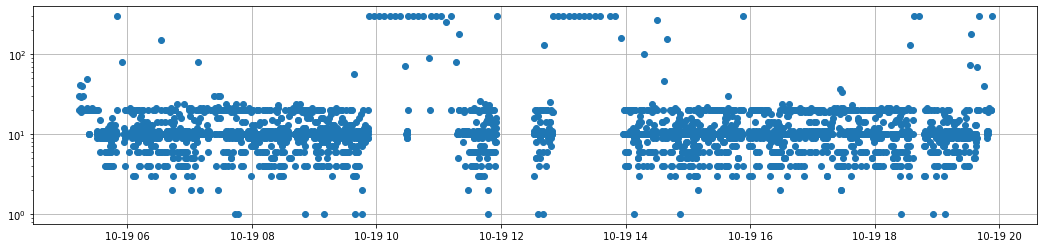

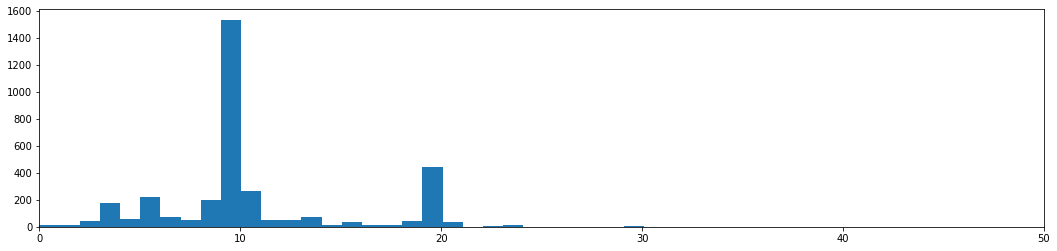

'5'(3502)
Max update time 2090


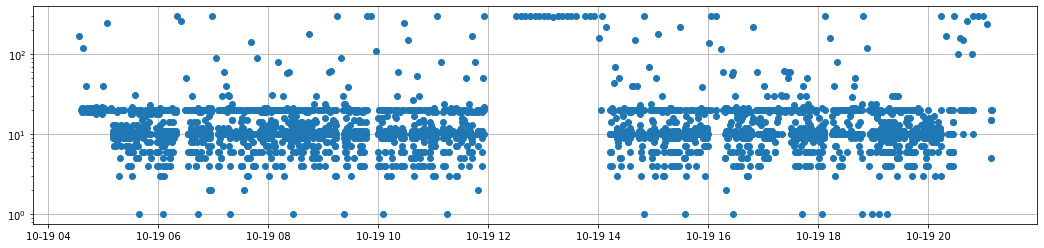

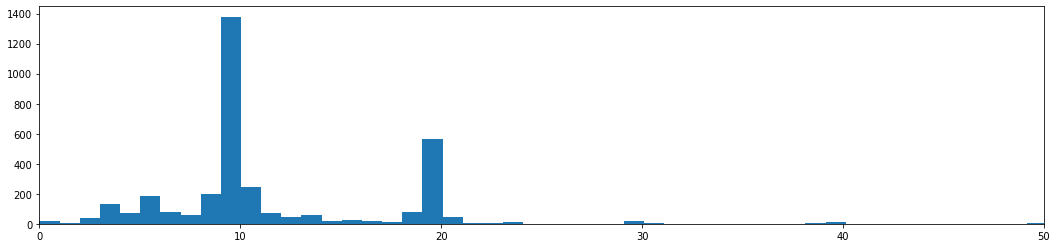

'34'(3496)
Max update time 2131


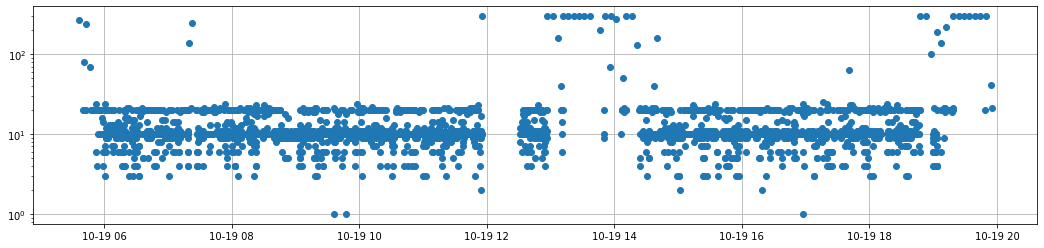

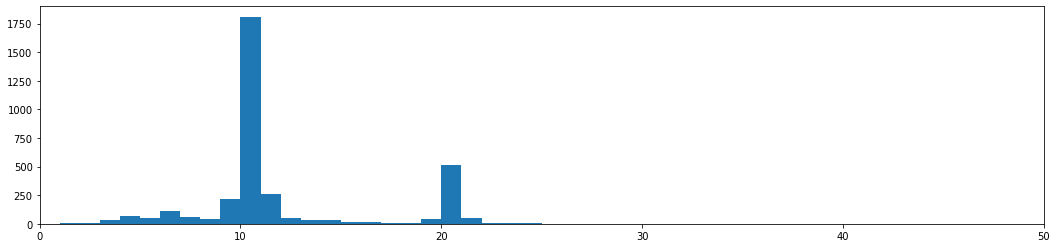

'6/6a'(2885) -> 'T'(595)
Max update time 2122


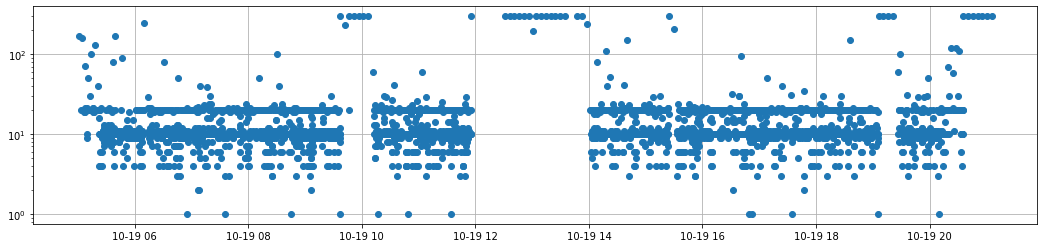

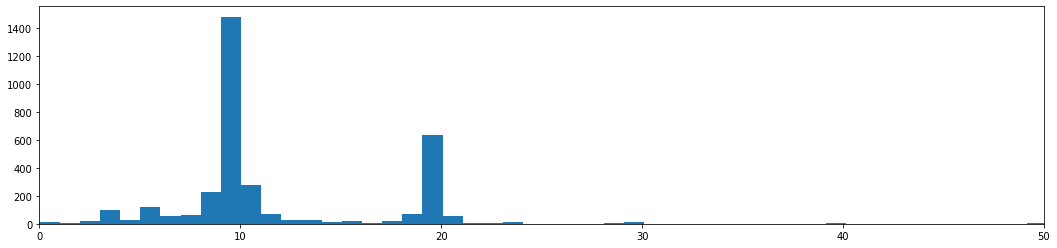

'6/6a'(3472)
Max update time 2092


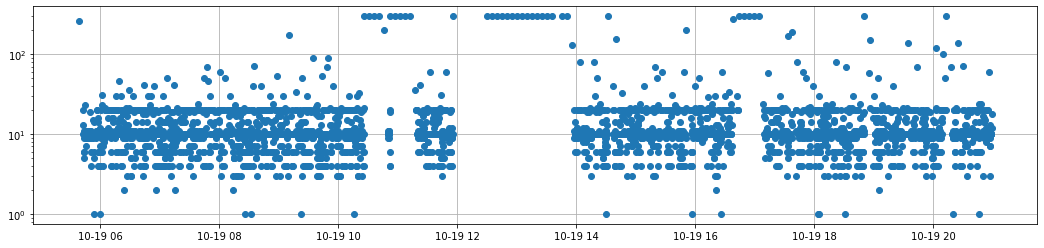

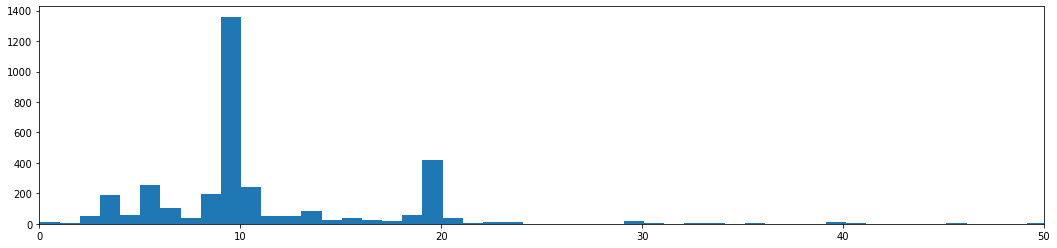

'3/3a'(3380)
Max update time 2474


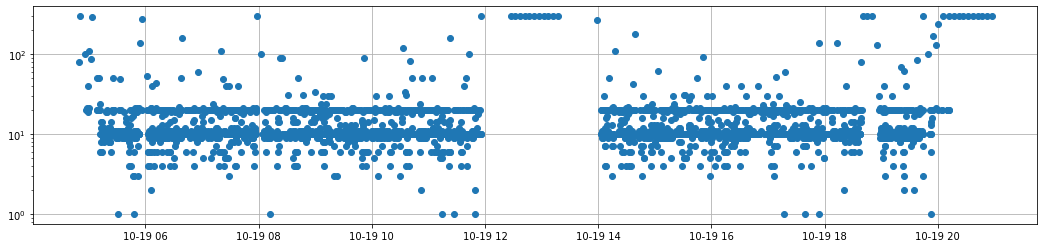

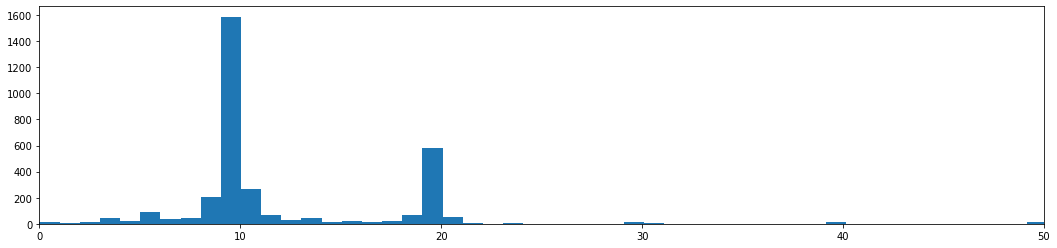

'5'(3056) -> 'A'(305) -> '13'(3)
Max update time 1850


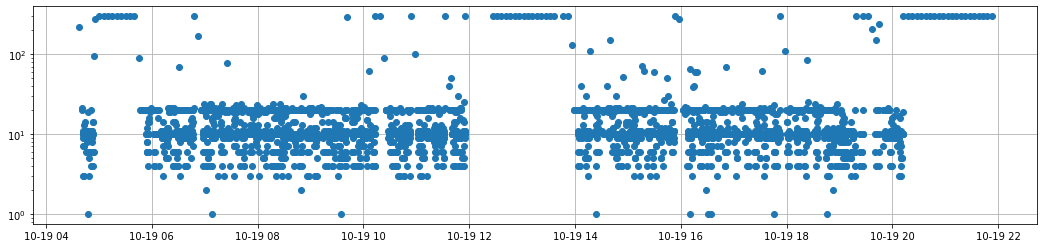

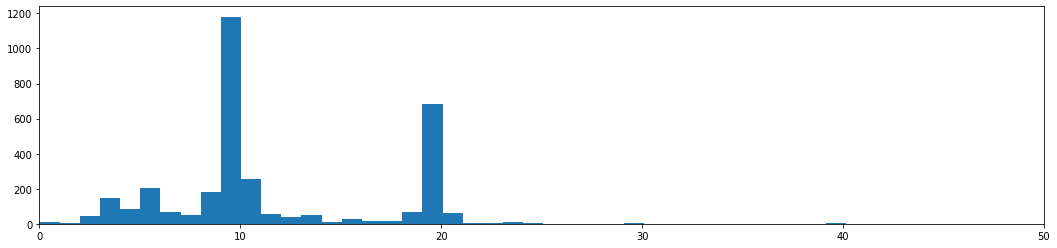

'4'(3350) -> '27'(7)
Max update time 2132


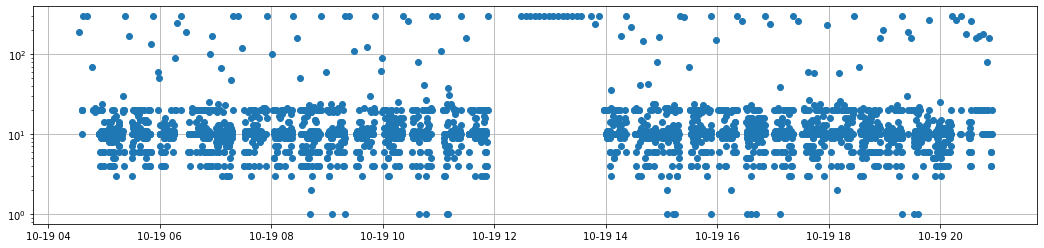

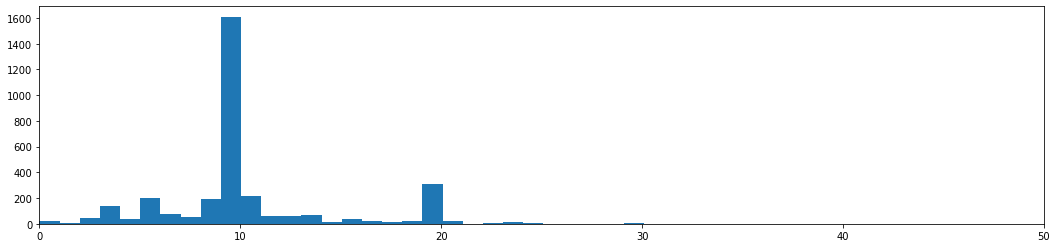

'4'(3173) -> '6'(177)
Max update time 2015


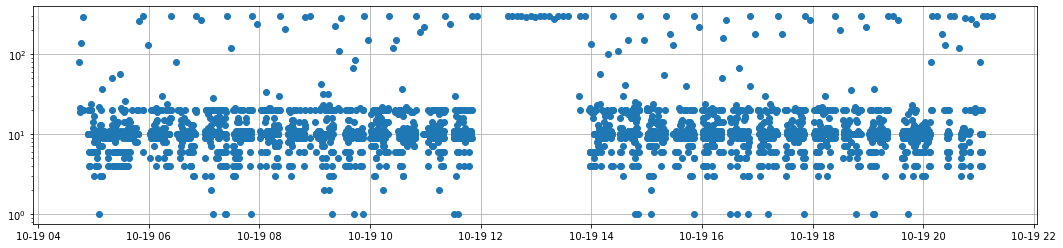

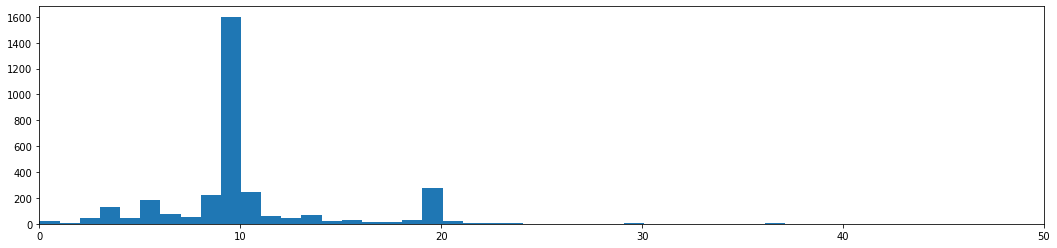

'5'(3291) -> 'A'(23)
Max update time 1941


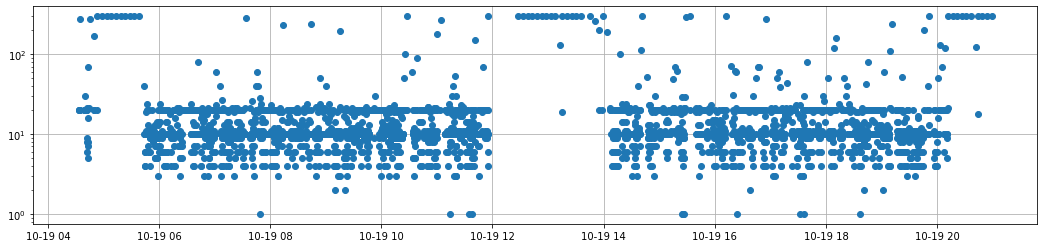

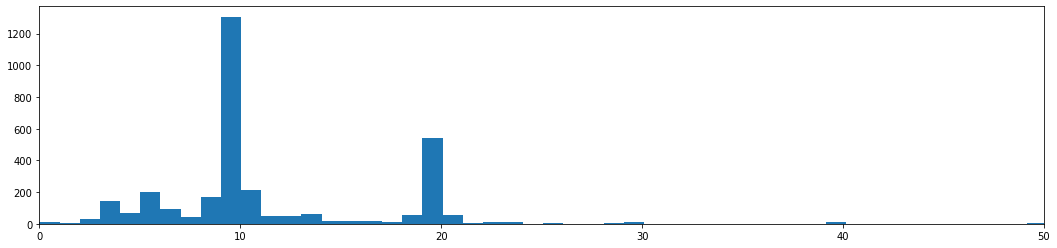

'12'(3289)
Max update time 5354


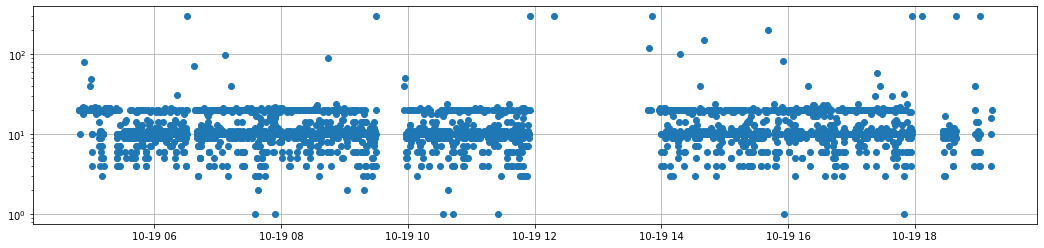

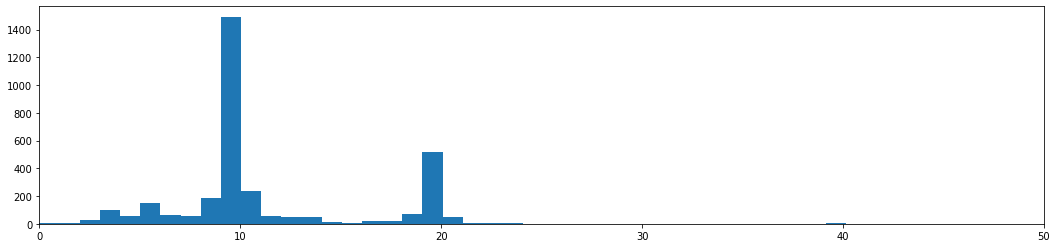

'5'(3248)
Max update time 2142


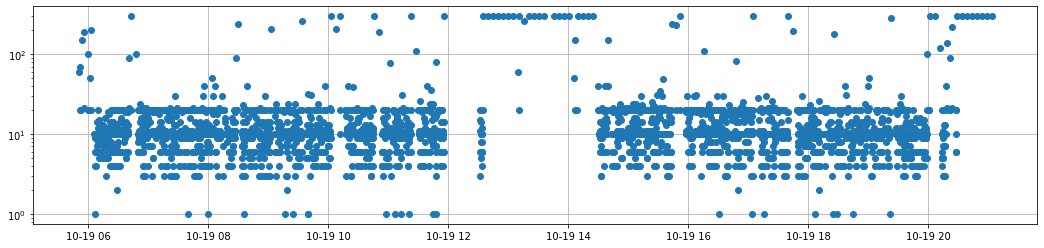

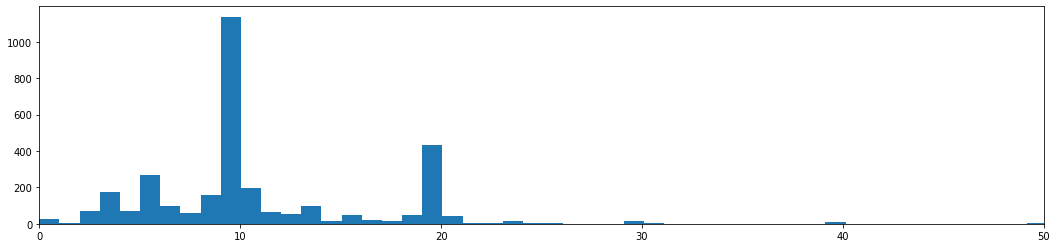

'5'(3223)
Max update time 2041


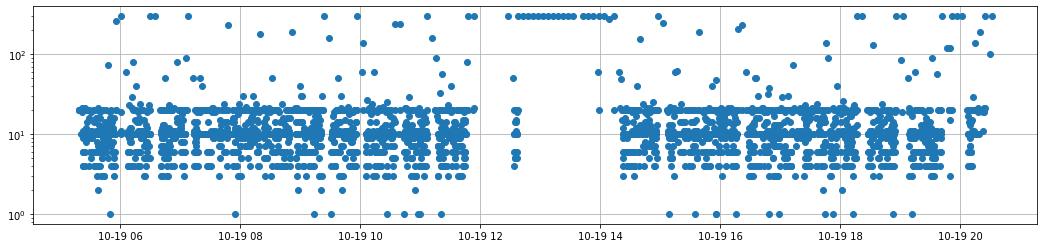

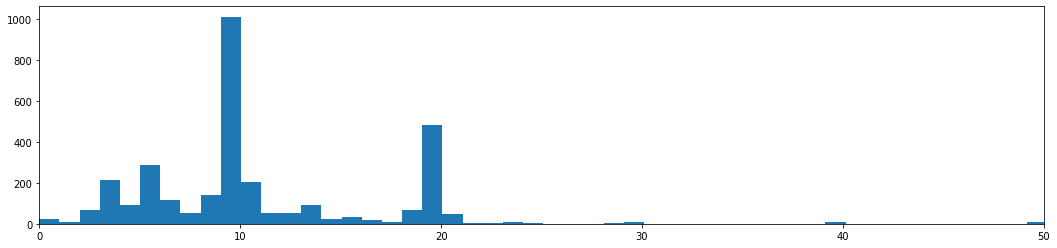

'2T'(2963) -> 'T'(258)
Max update time 2032


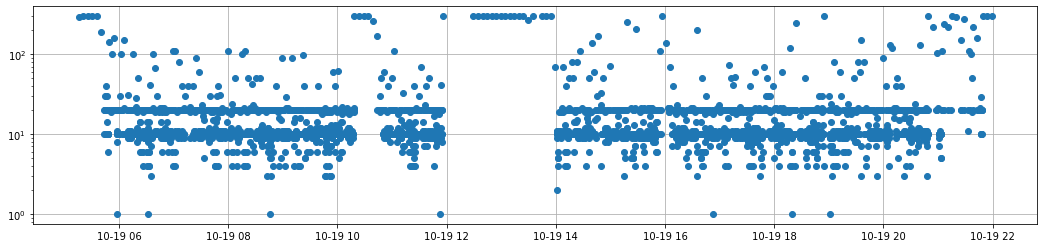

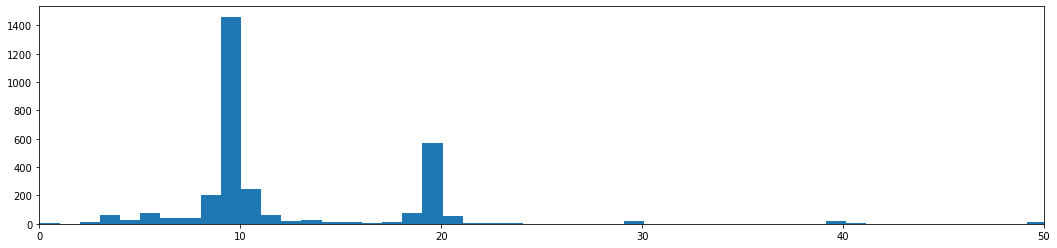

'T'(1267) -> '5T'(1117) -> '3/3a'(659) -> '4T'(133)
Max update time 17282


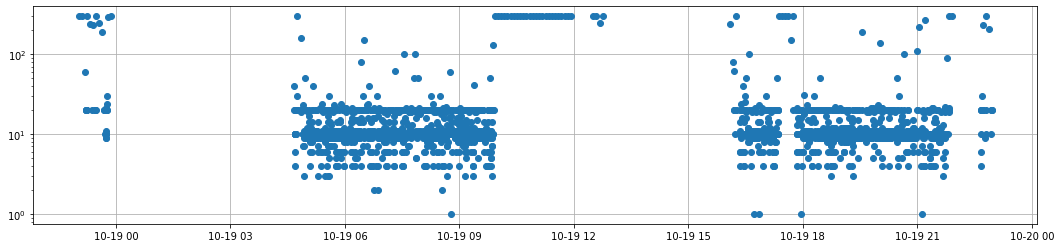

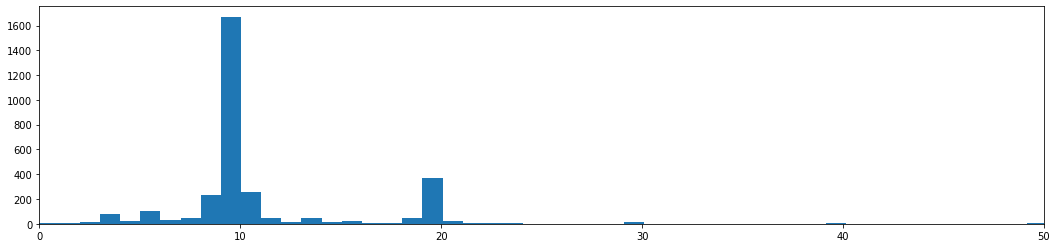

'12'(3172)
Max update time 1932


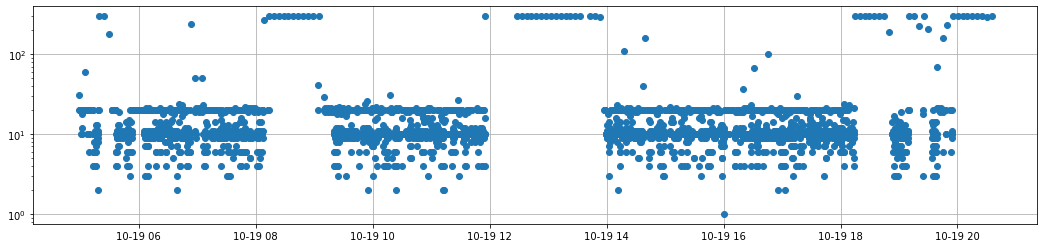

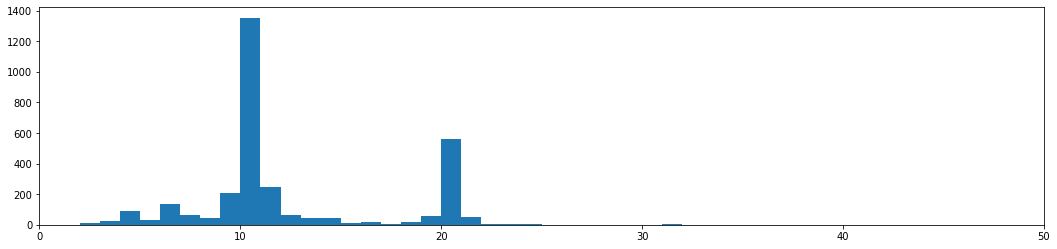

'9A'(3164)
Max update time 2131


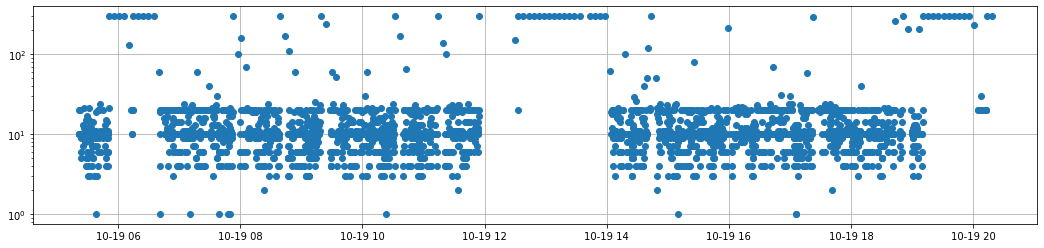

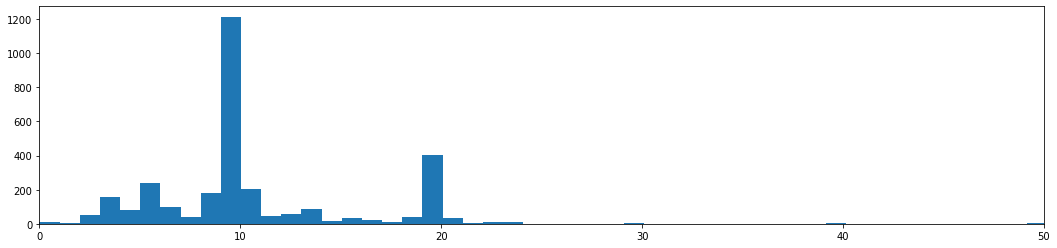

'6'(3122)
Max update time 4514


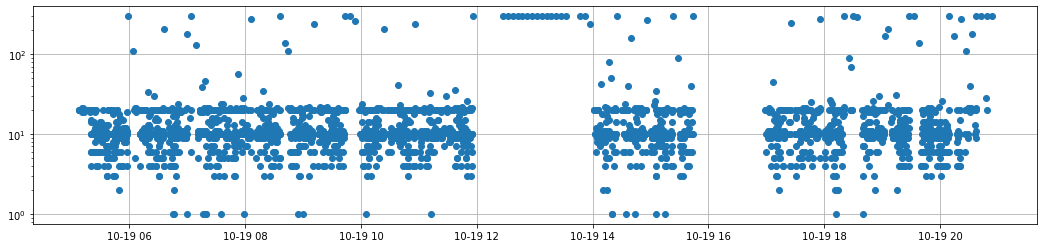

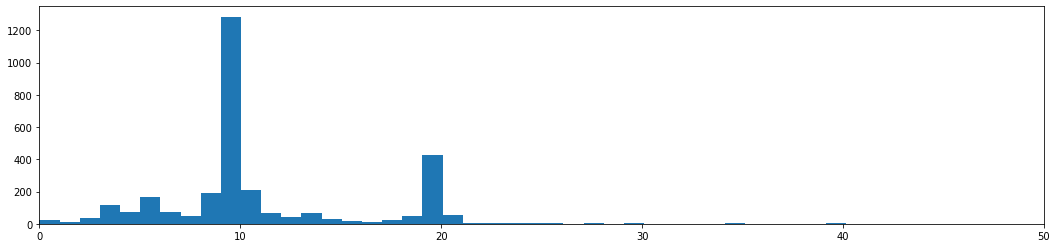

'9A'(3004)
Max update time 4898


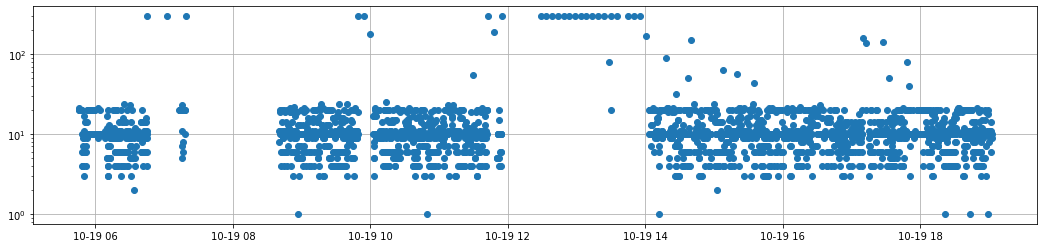

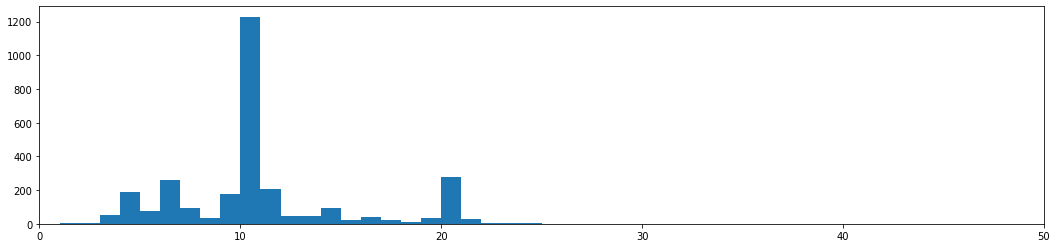

'13'(2929)
Max update time 12823


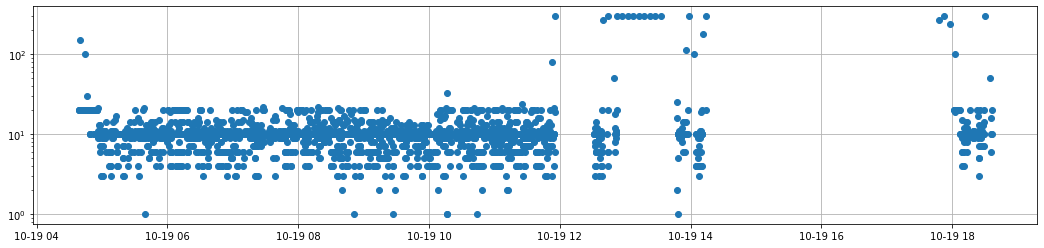

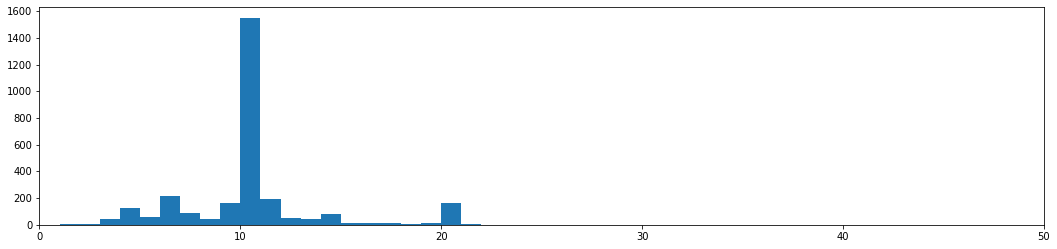

'5'(2841) -> '6'(1)
Max update time 1961


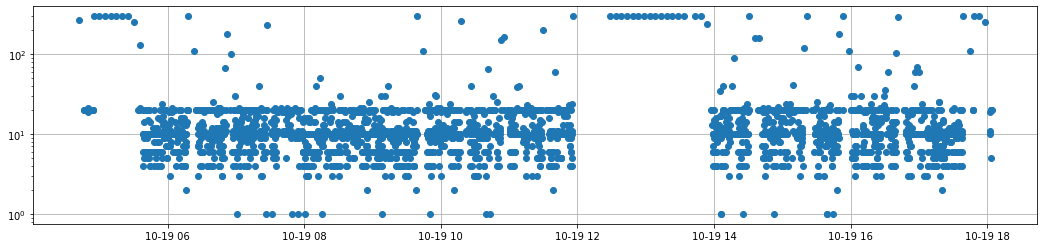

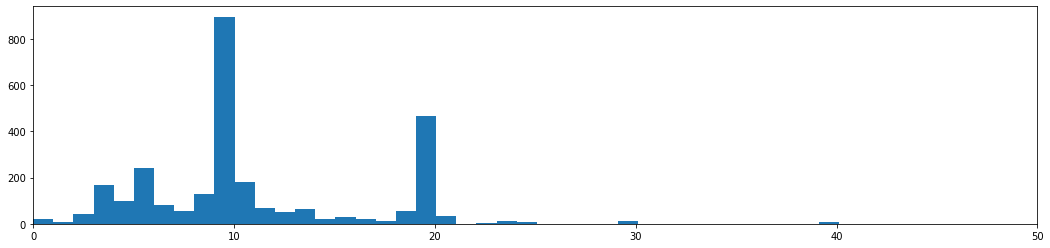

'34'(2695) -> 'A'(128)
Max update time 8408


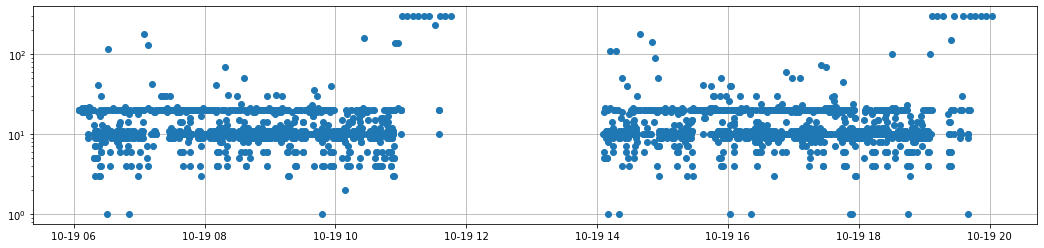

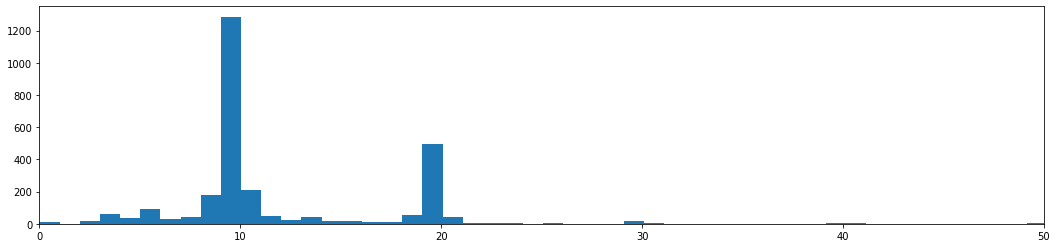

'6/6a'(2791)
Max update time 2072


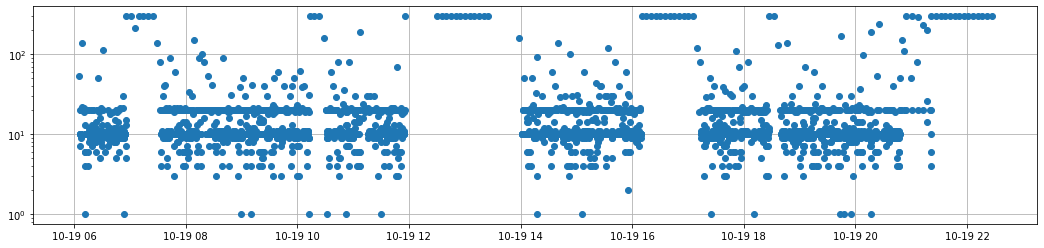

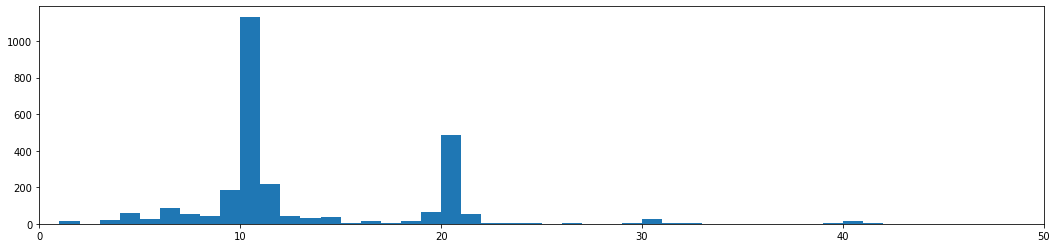

'10'(2789)
Max update time 2137


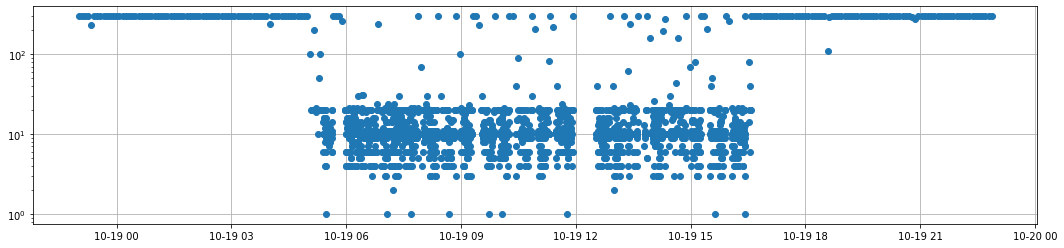

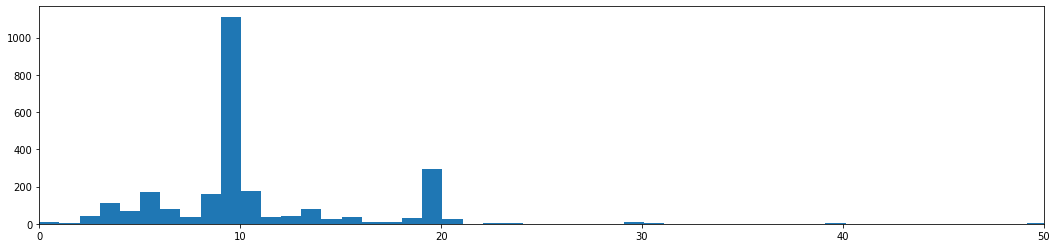

'2A'(2443) -> '2'(236)
Max update time 2132


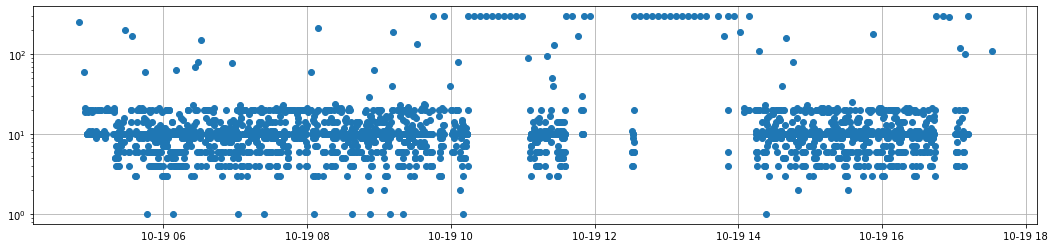

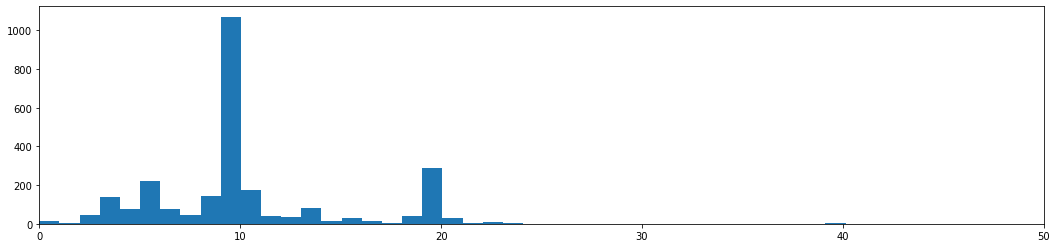

'2A'(2478) -> '20'(188)
Max update time 1996


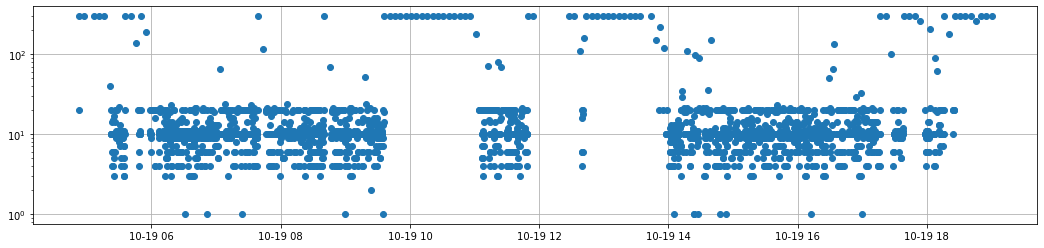

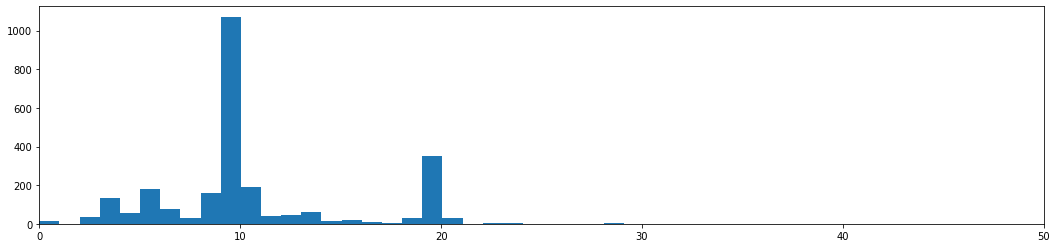

'11'(2509)
Max update time 4234


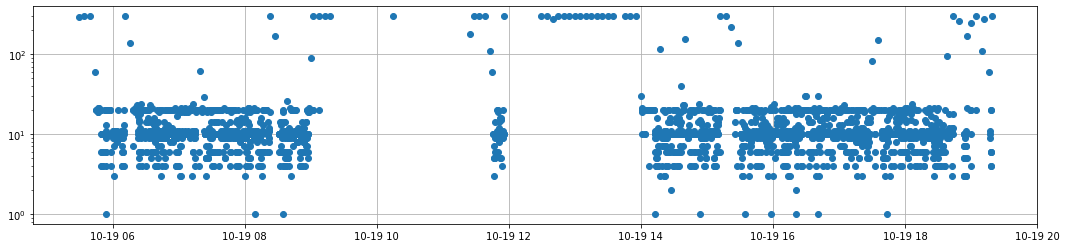

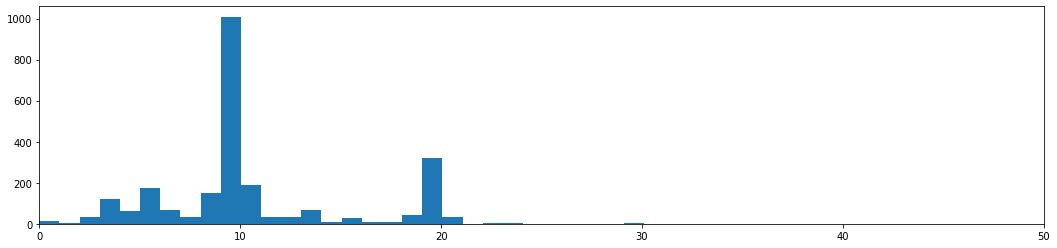

'3/3a'(1487) -> 'T'(1003)
Max update time 16433


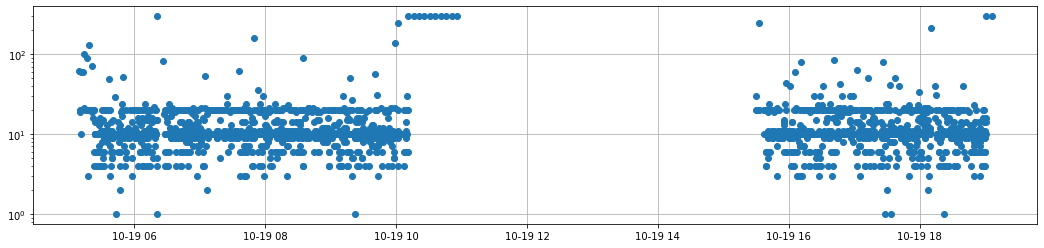

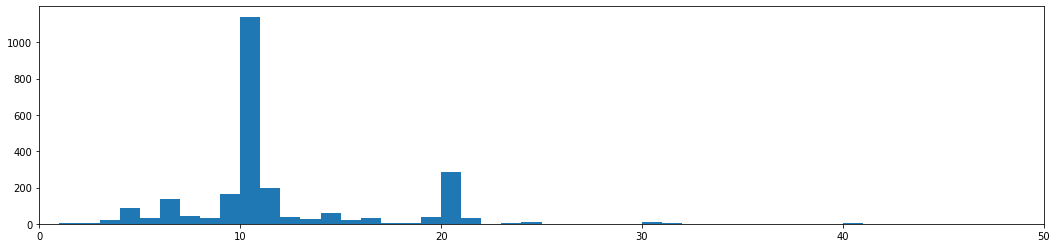

'10'(2447)
Max update time 2406


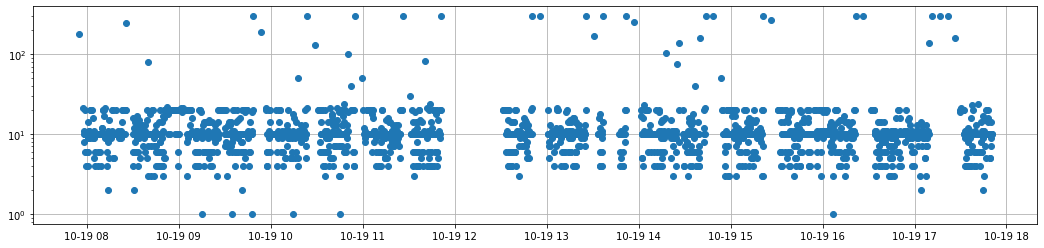

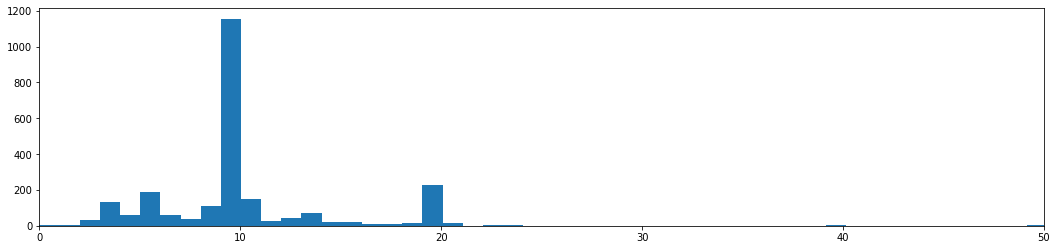

'2'(2217) -> '20'(132)
Max update time 2102


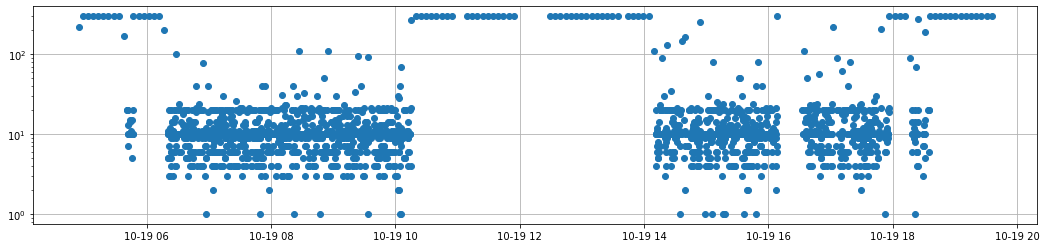

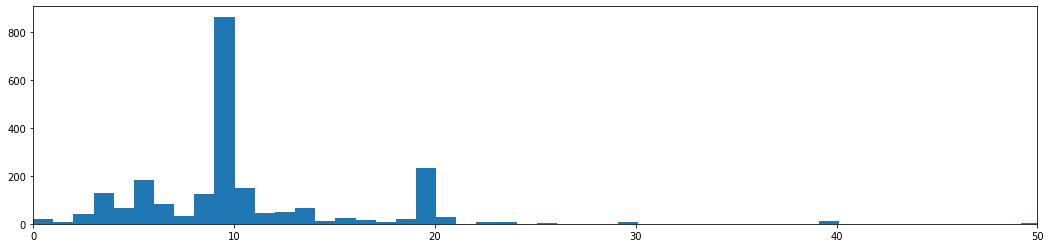

'27'(2300) -> '4'(45)
Max update time 2331


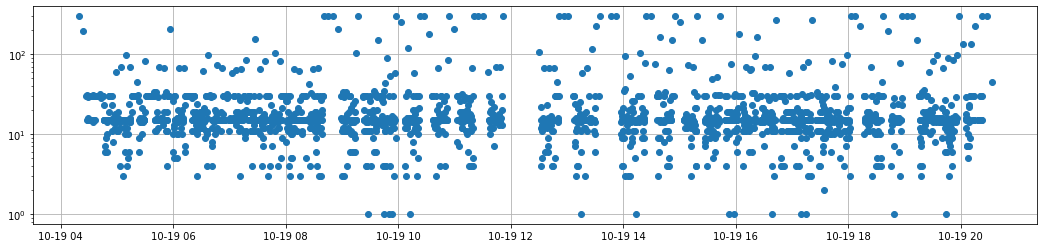

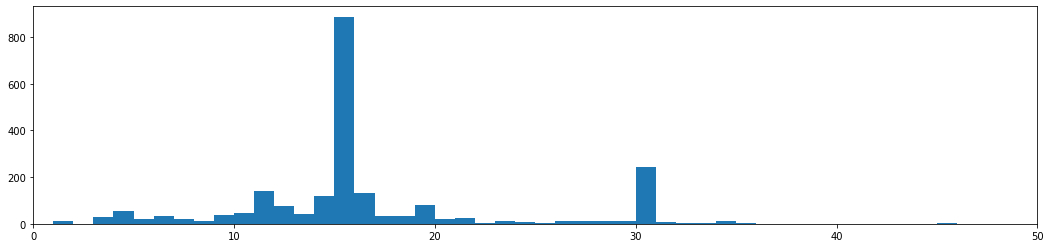

'6/6a'(1195) -> 'T'(1048)
Max update time 2103


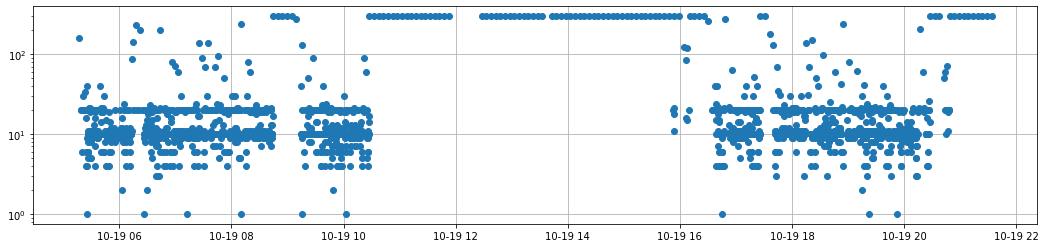

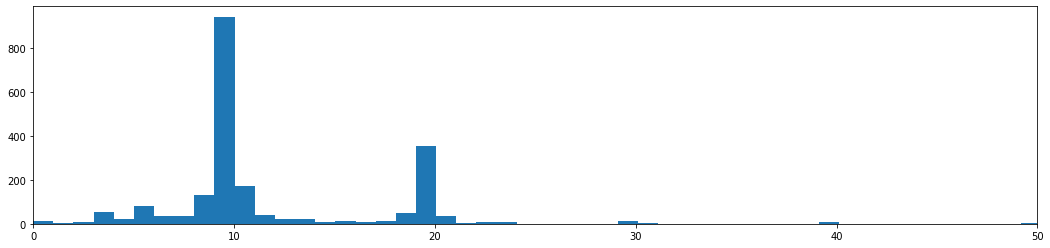

'9A'(2063) -> 'A'(99)
Max update time 1261


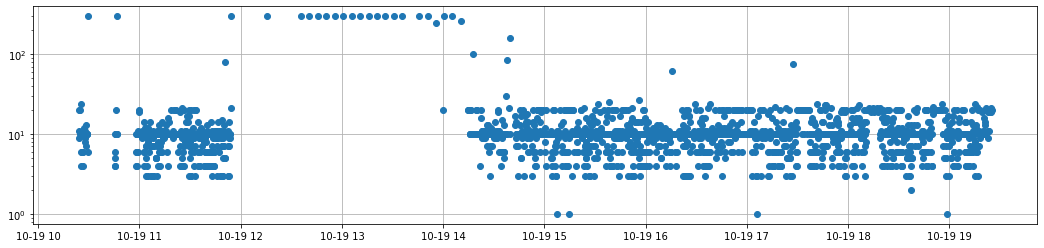

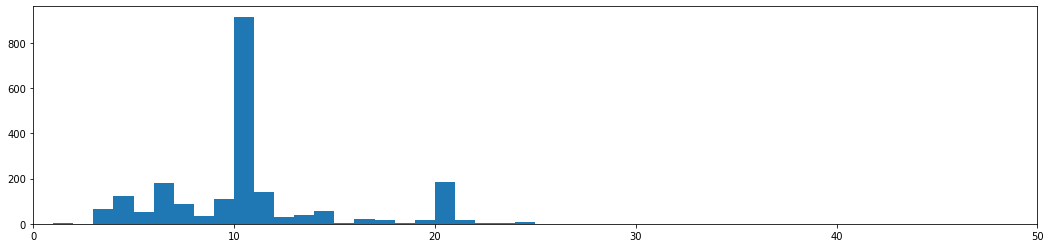

'3/3a'(1068) -> 'T'(907) -> '2T'(96)
Max update time 1980


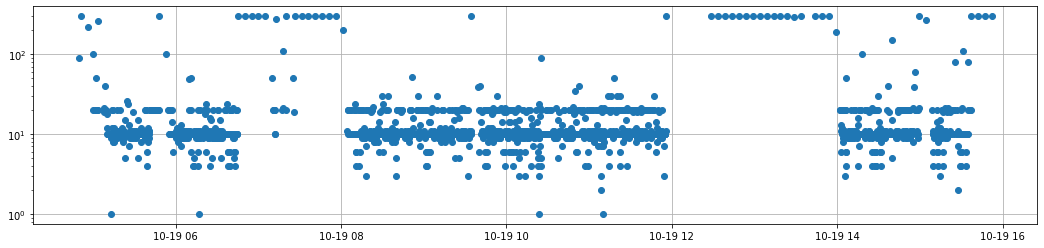

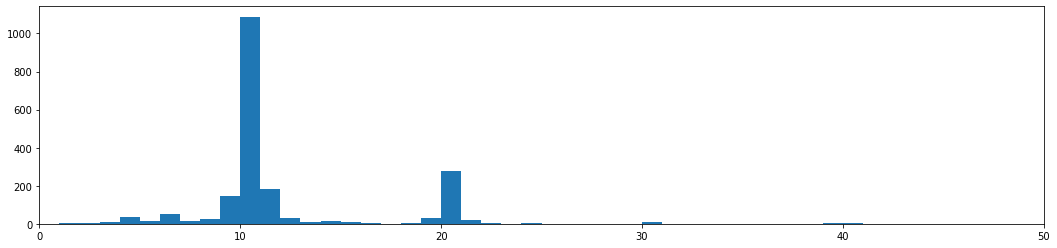

'23'(1593) -> '11'(330)
Max update time 6927


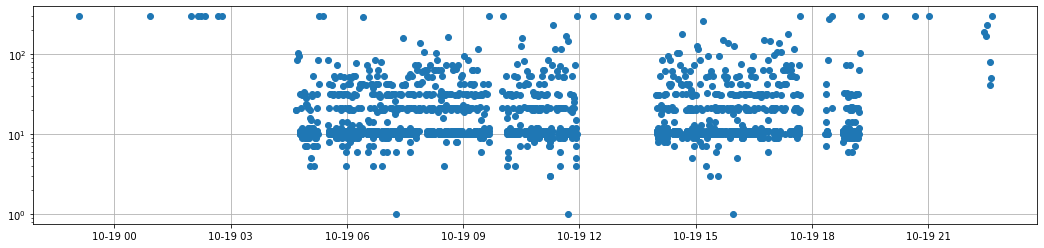

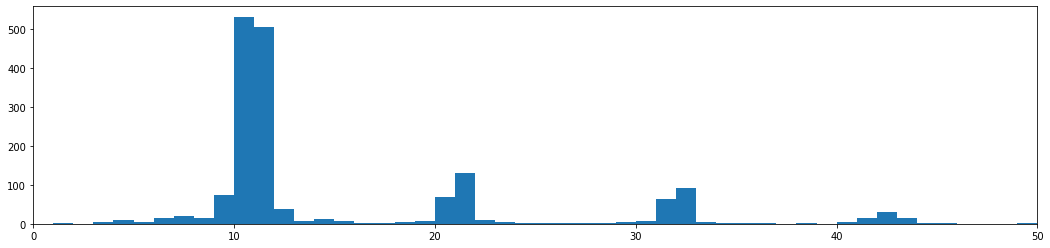

'5'(1869)
Max update time 3057


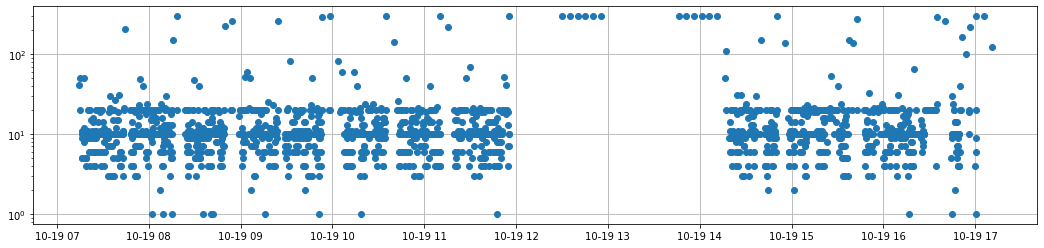

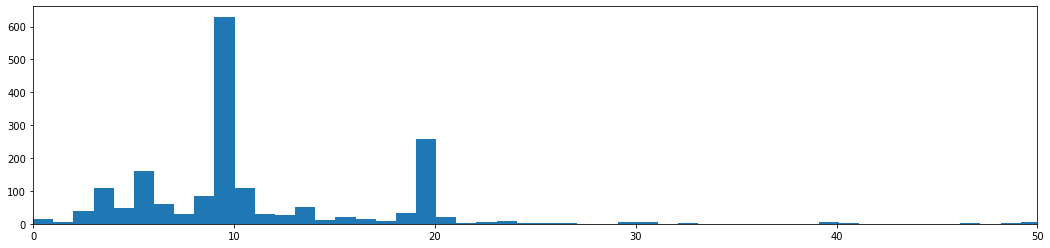

'1'(1814)
Max update time 2843


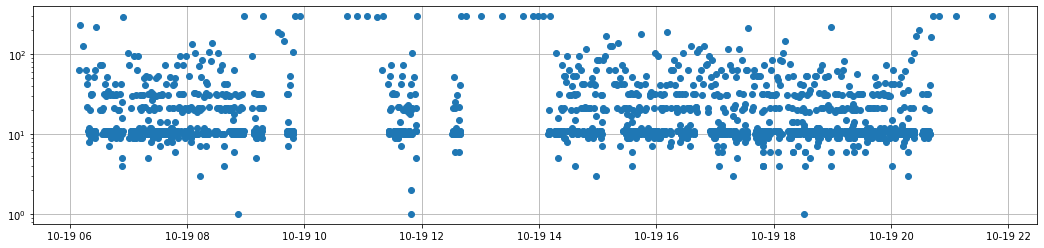

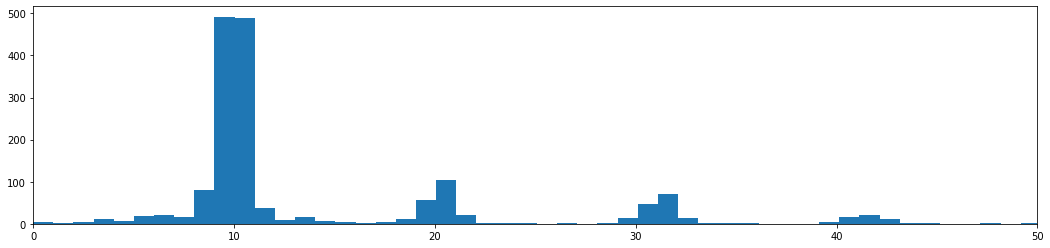

'11'(1779)
Max update time 2996


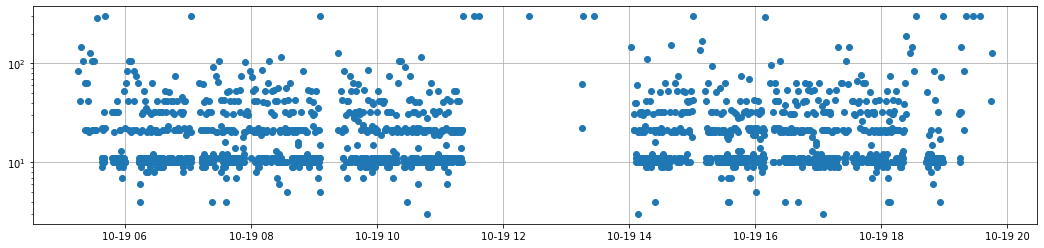

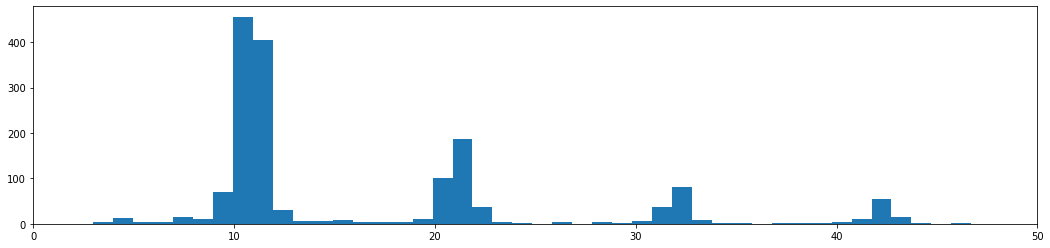

'39'(1756)
Max update time 759


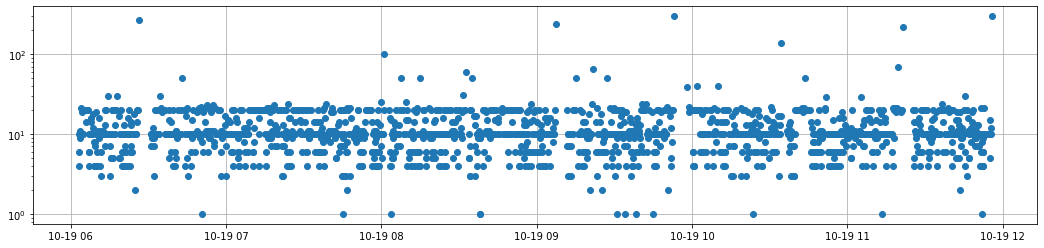

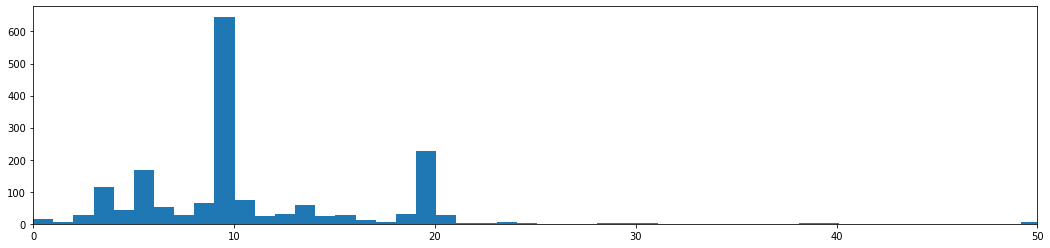

'2T'(1436) -> 'T'(235)
Max update time 21344


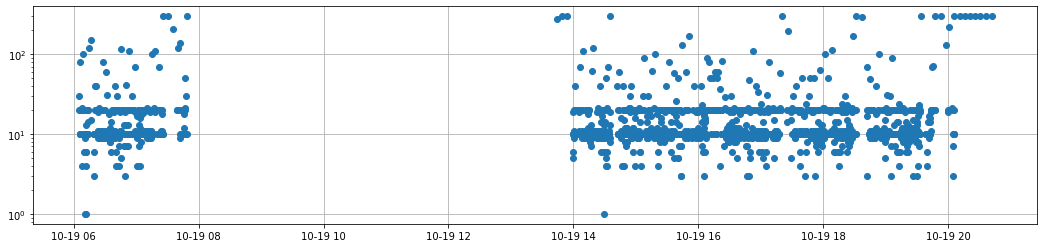

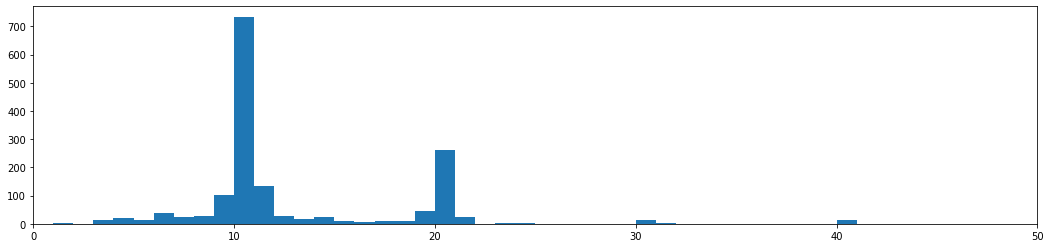

'1'(1350) -> '38'(163) -> '1A'(101)
Max update time 3249


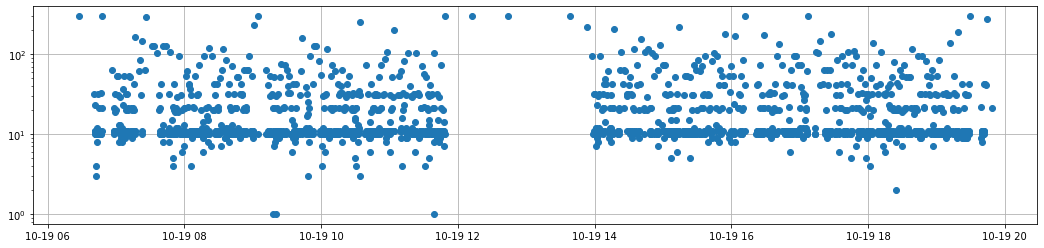

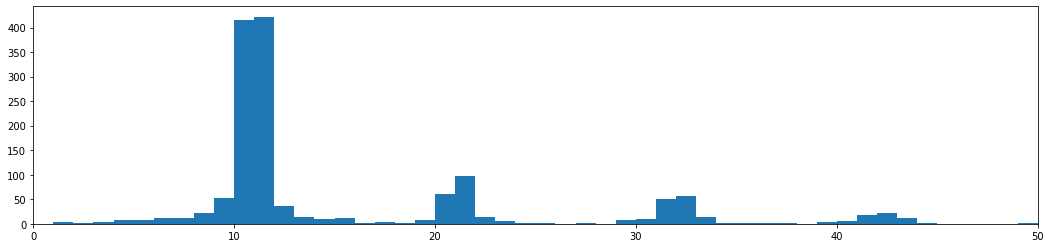

'2'(1122) -> '2A'(477)
Max update time 1927


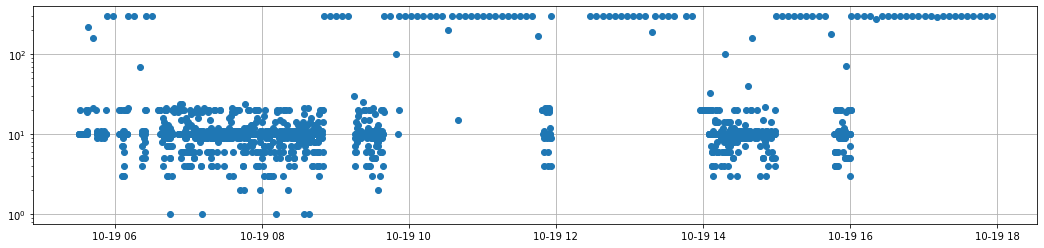

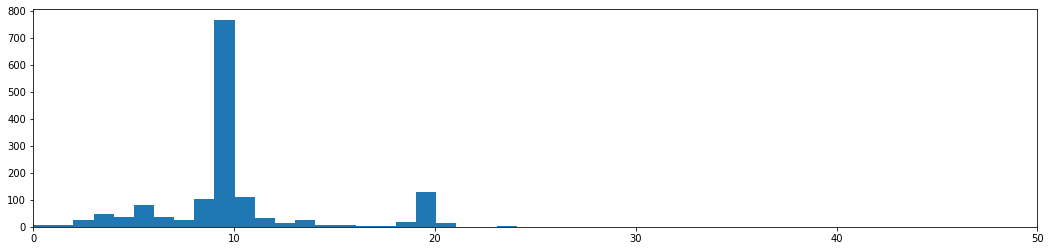

'3/3a'(852) -> 'T'(532)
Max update time 20955


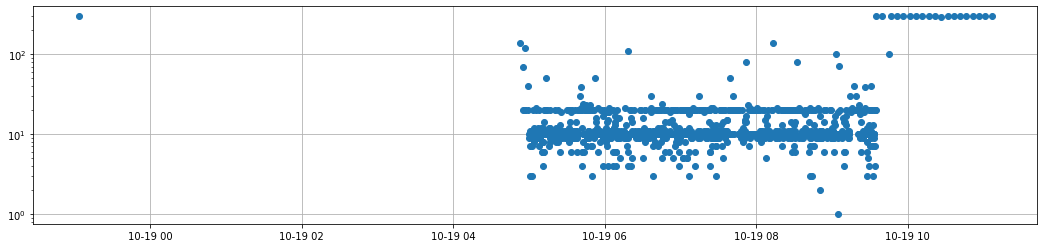

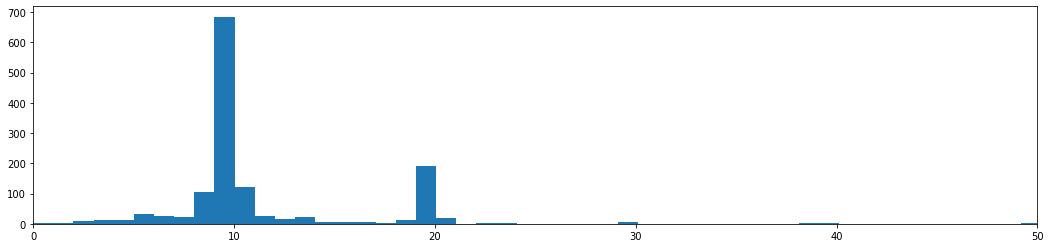

'38'(1383)
Max update time 9504


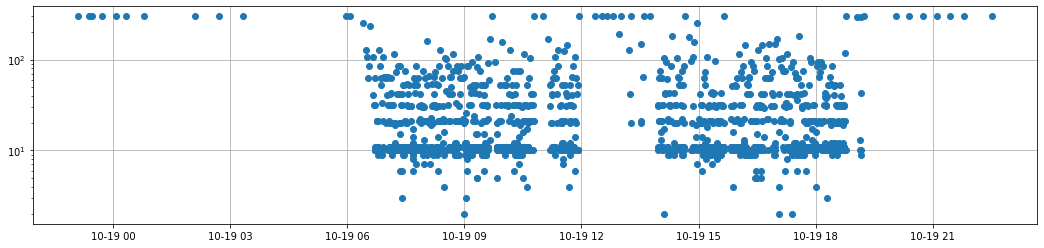

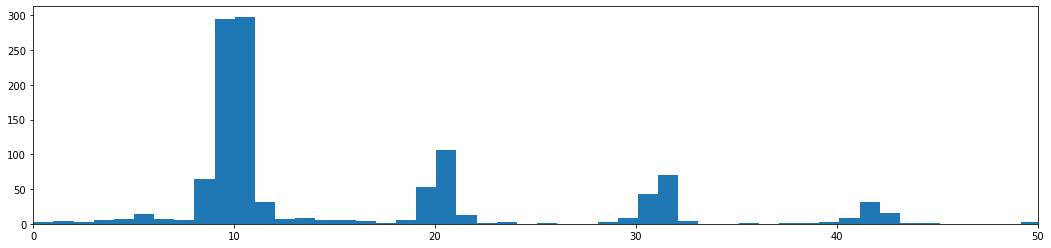

'3/3a'(823) -> 'T'(536)
Max update time 14282


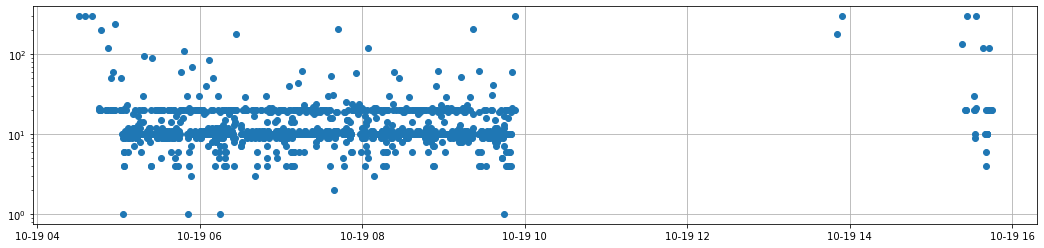

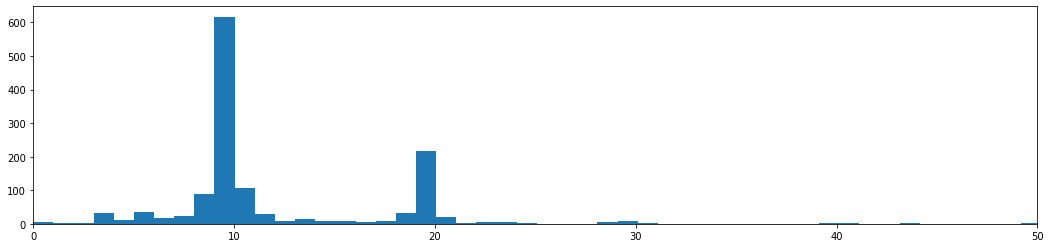

'38'(1332)
Max update time 4997


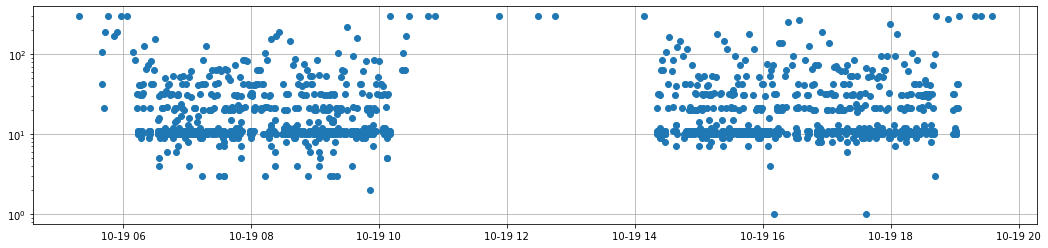

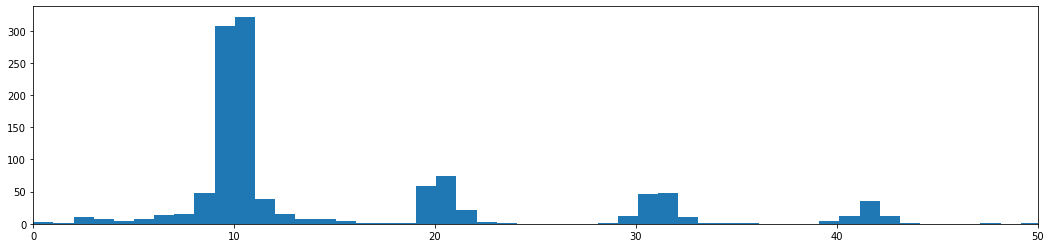

'1T'(797) -> 'T'(328)
Max update time 301


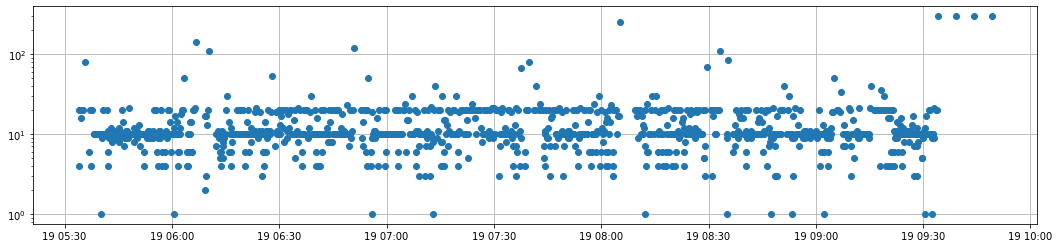

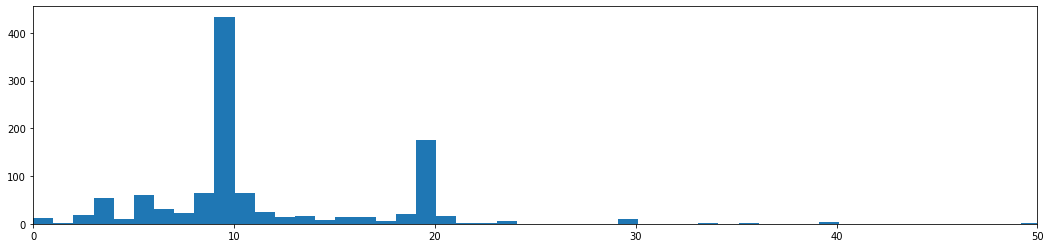

'11'(711)
Max update time 1993


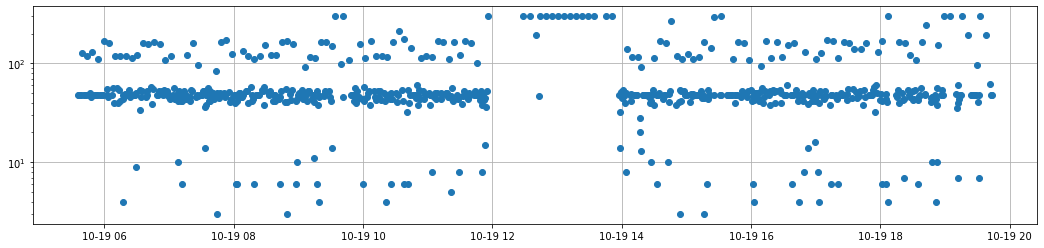

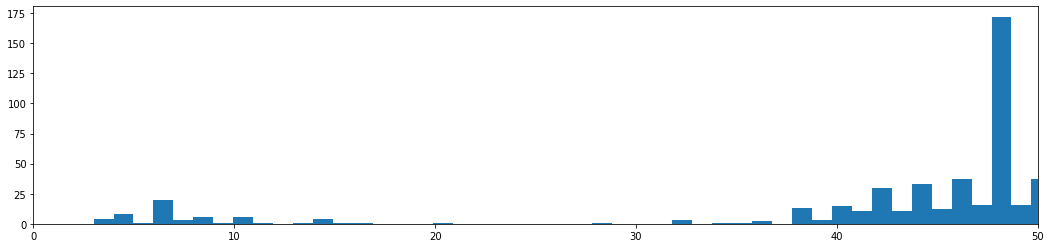

'38'(607) -> '1A'(57)
Max update time 3454


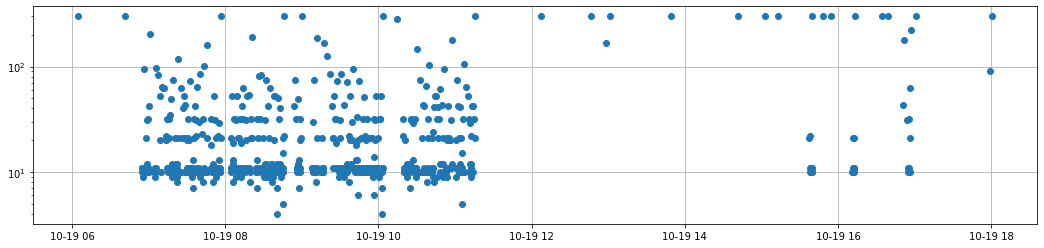

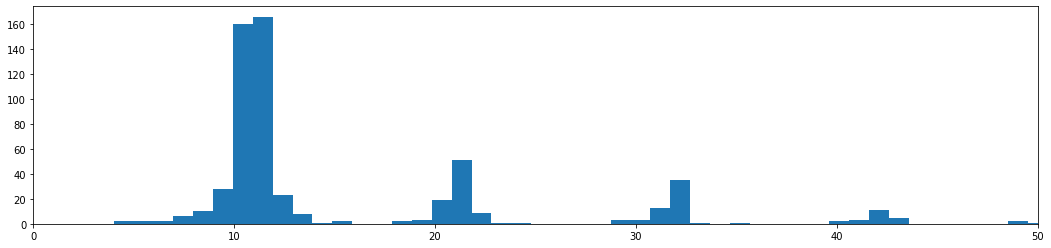

'12'(576)
Max update time 28926


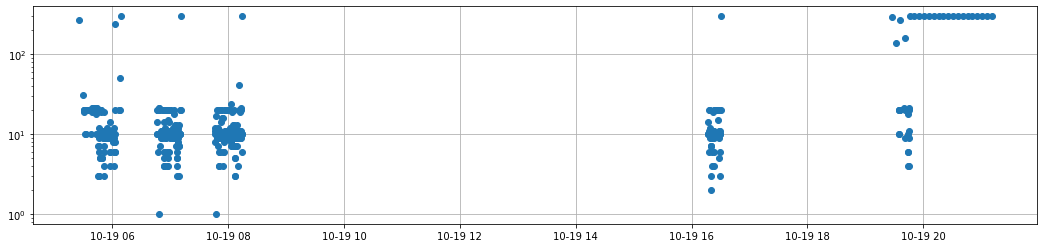

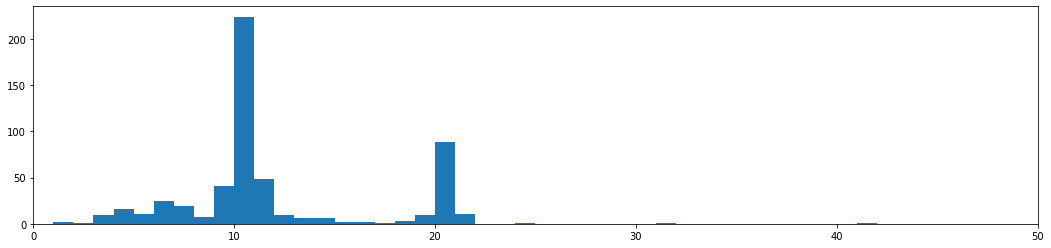

'9'(401)
Max update time 13136


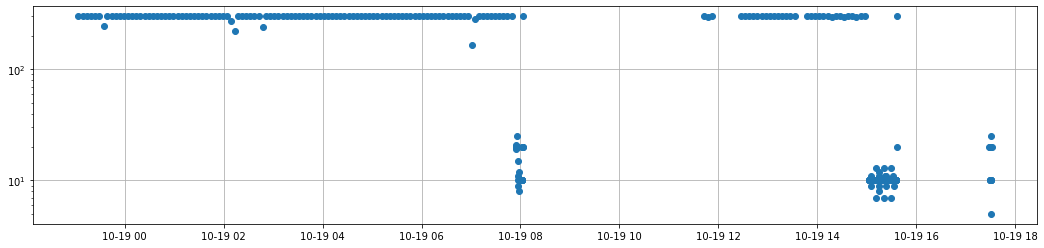

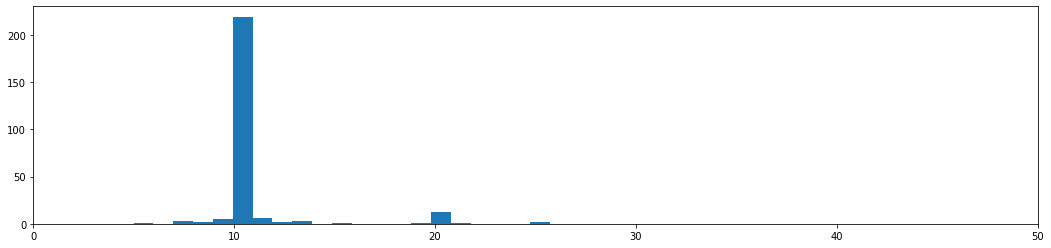

'39'(373)
Max update time 2102


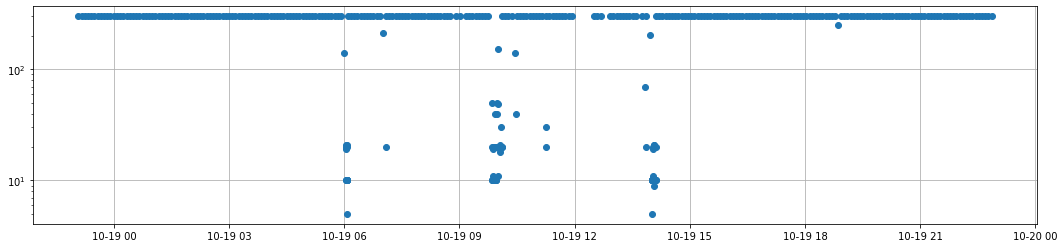

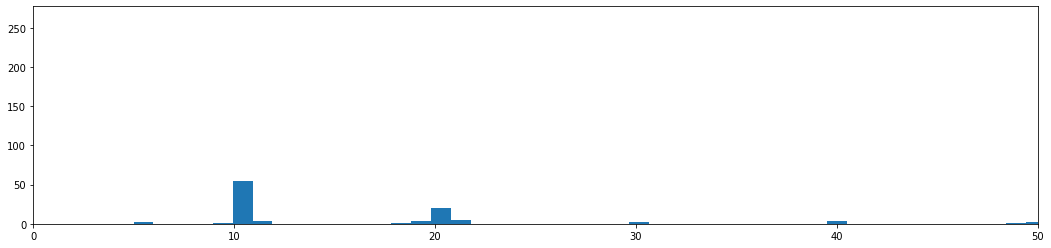

'34'(318) -> 'A'(5)
Max update time 4582


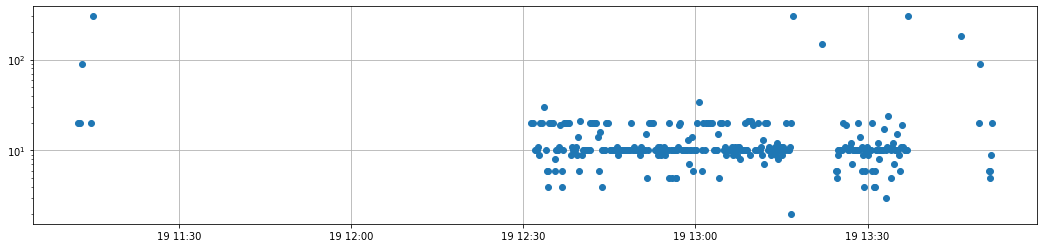

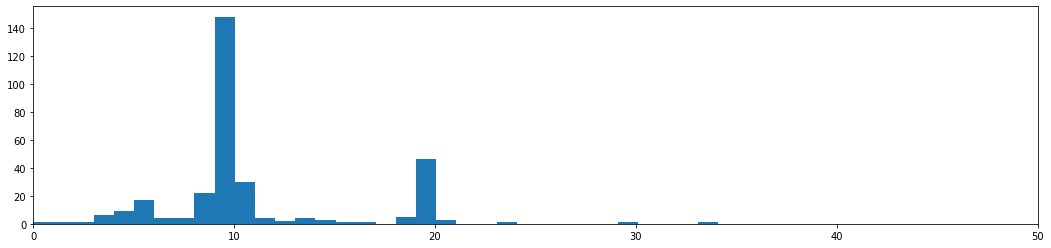

'T'(320)
Max update time 2108


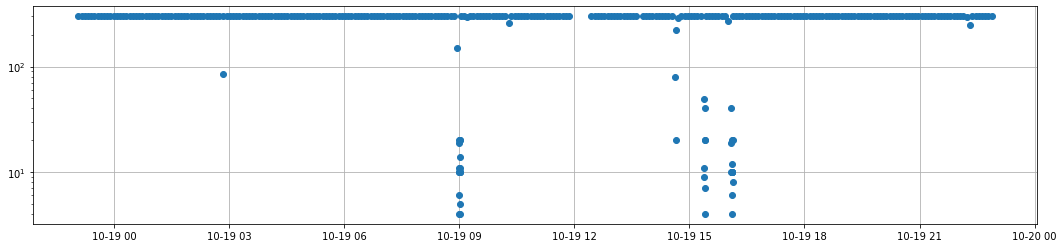

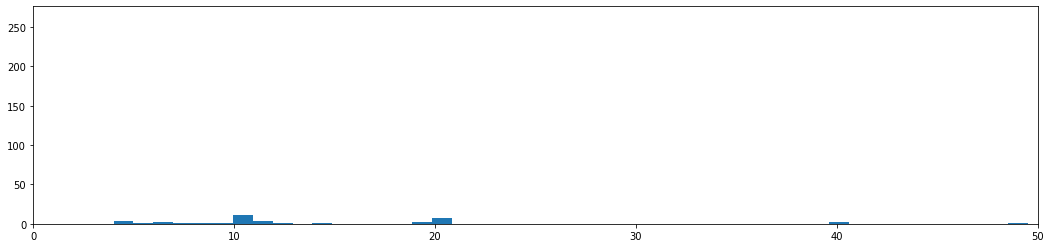

'A'(197)
Max update time 2402


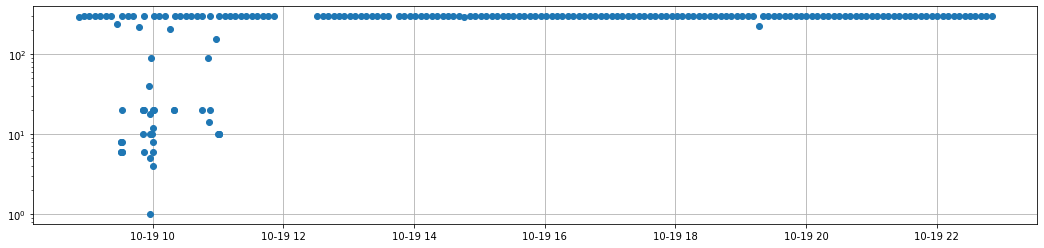

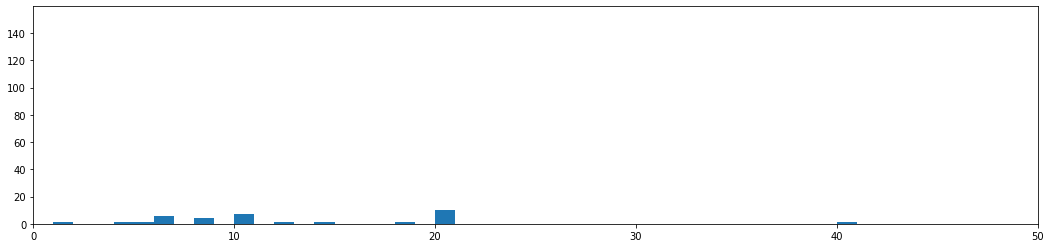

'A'(112)
Max update time 2102


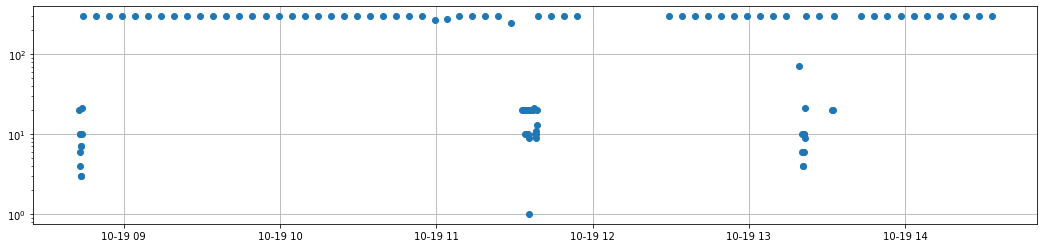

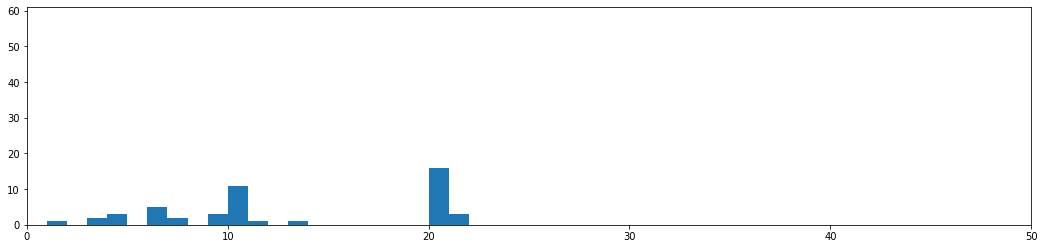

'3/3a'(109)
Max update time 4318


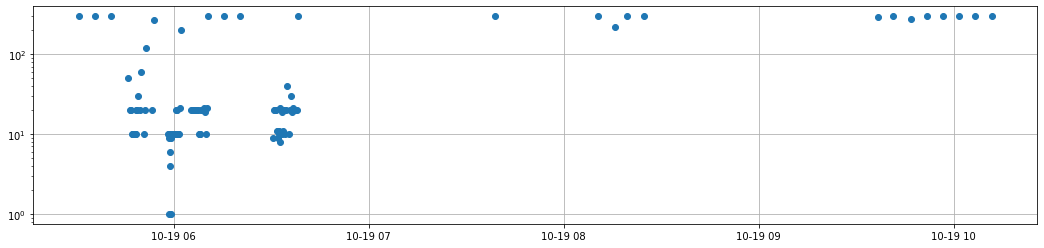

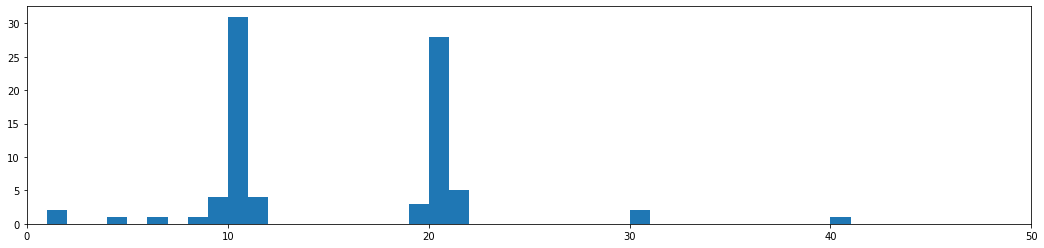

'T'(54)
Max update time 321


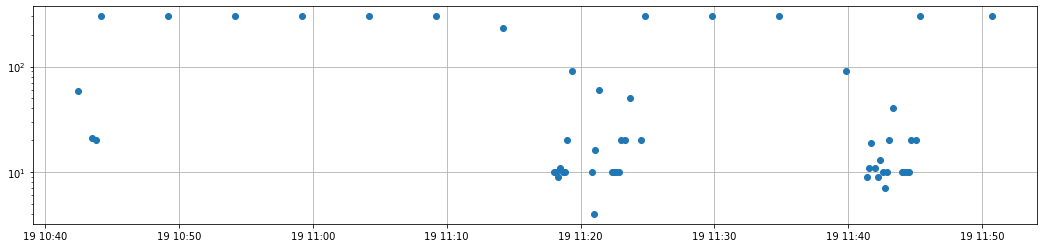

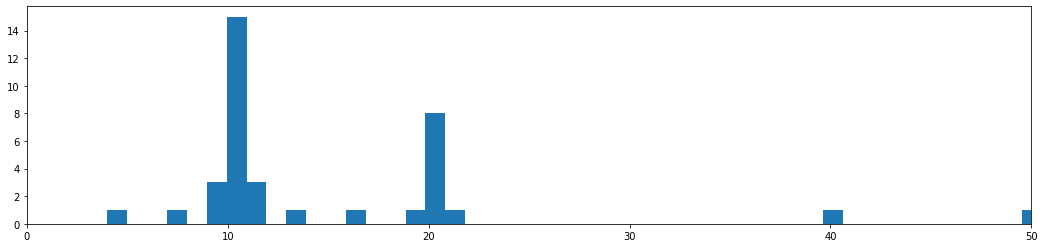

'1'(36)
Max update time 9014


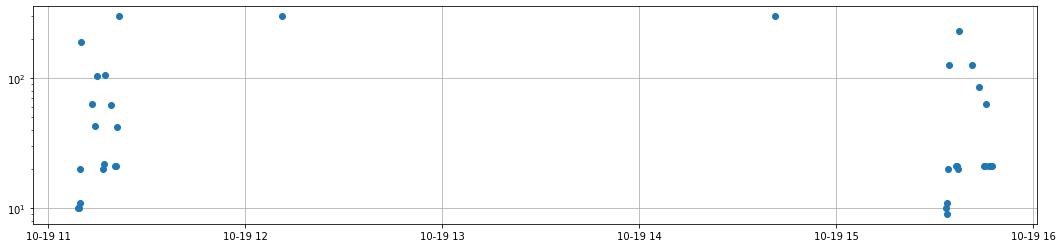

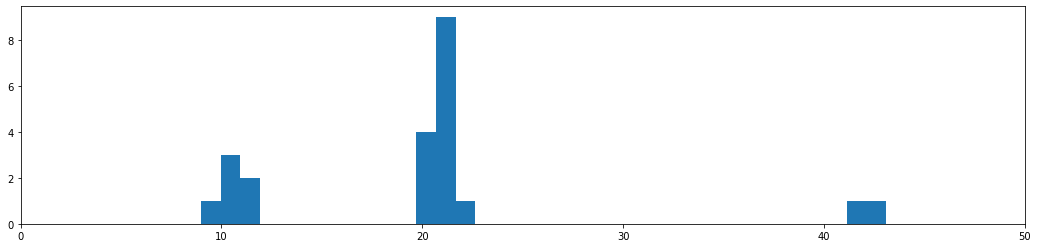

'A'(26)
Max update time 301


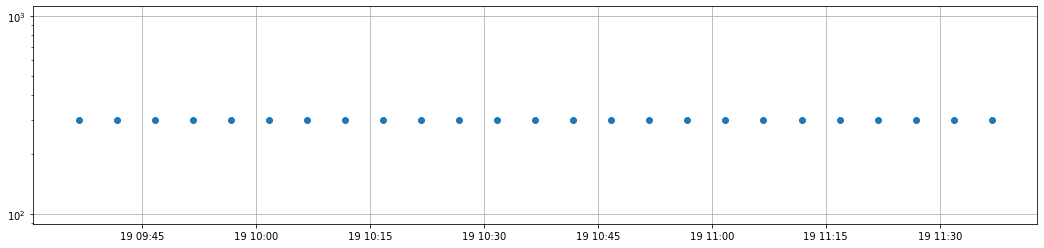

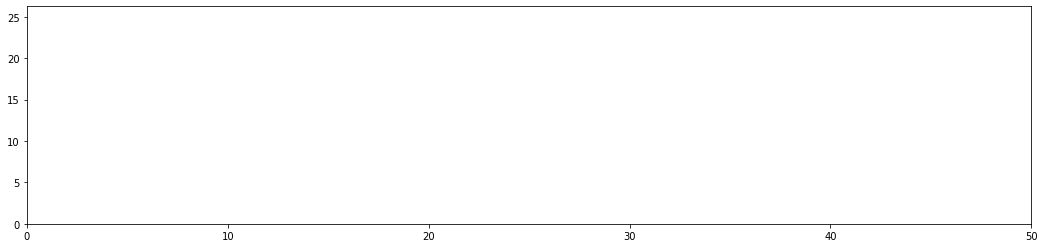

'A'(21)
Max update time 2223


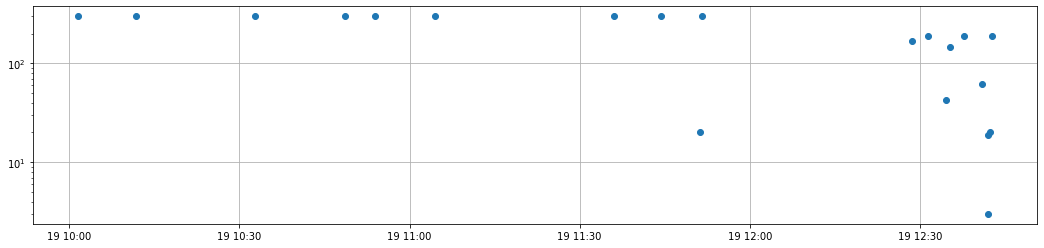

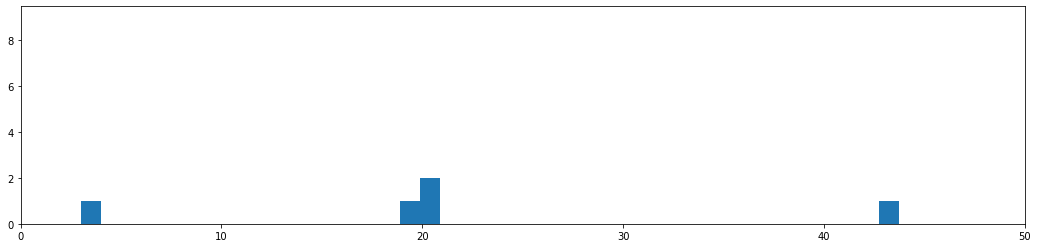

'2'(21)
Max update time 11


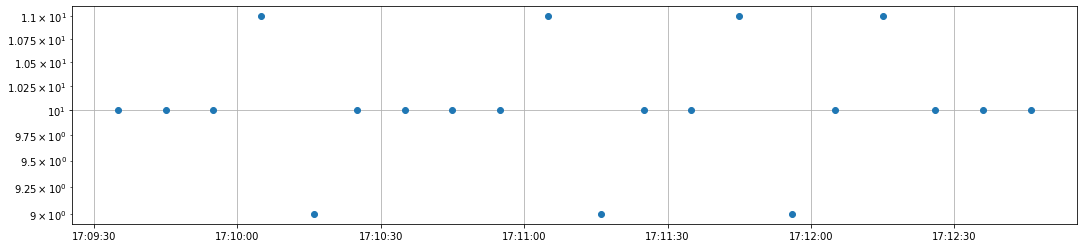

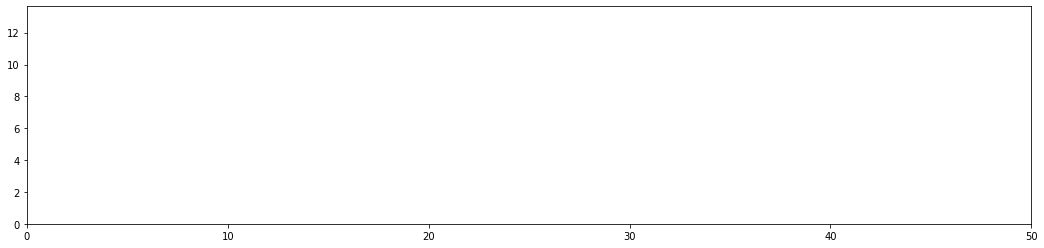

'38'(14)
Max update time 4954


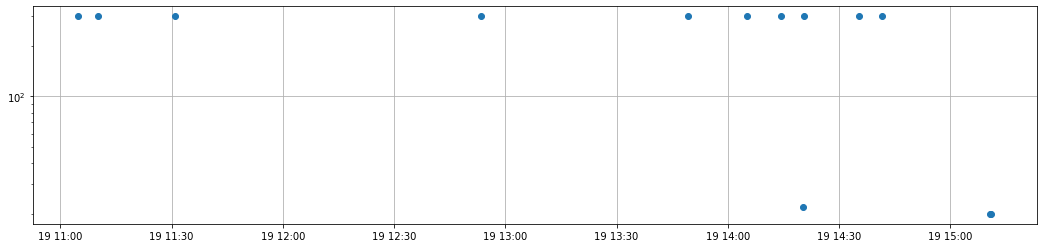

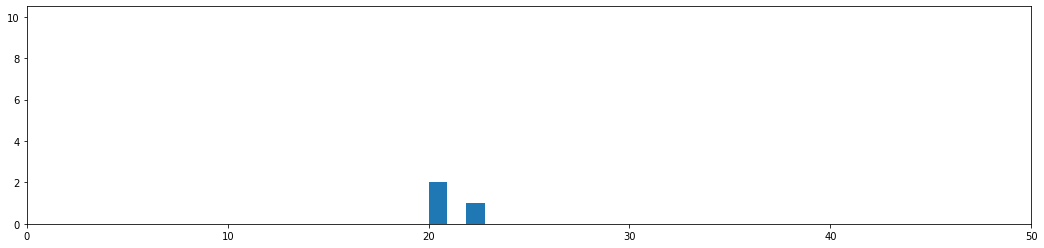

'25'(8)
Max update time 21


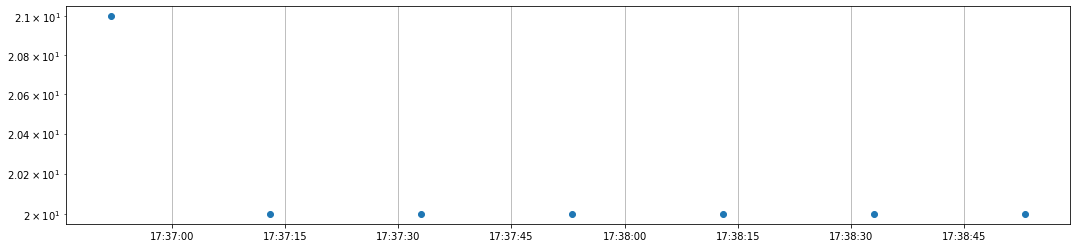

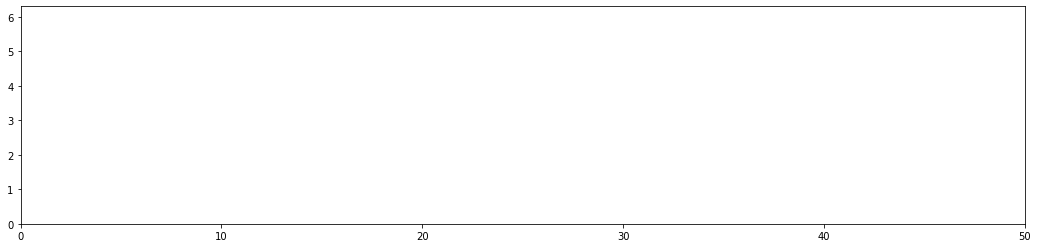

ValueError: max() arg is an empty sequence

In [7]:
import matplotlib 

for imei, cnt in sum_df['imei'].value_counts().items():

    frame = sum_df[sum_df['imei'] == imei]
    dttm = frame['gpstime'].apply(lambda x : datetime.strptime(x, "%Y-%m-%d %H:%M:%S")).values
    dttm.sort()
    dttm_delta = (dttm[1:] - dttm[:-1] ).astype('timedelta64[s]').astype(int)
     
    dttm_delta_max = max(dttm_delta)
    dttm_delta[dttm_delta > 60*5] = 300
    
    print(" -> ".join([f"'{r}'({cnt})" for r, cnt in frame['routeName'].value_counts().items()]))
    print(f"Max update time {dttm_delta_max}")
    
    plt.figure(figsize=(18, 4))
    x_values = dttm[:-1]
    y_values = dttm_delta

    dates = matplotlib.dates.date2num(x_values)

    plt.plot_date(dates, y_values)
    plt.yscale("log")
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(18, 4))
    plt.hist(dttm_delta, bins=60*5-1)
    plt.xlim([0, 50])
    plt.show()
    
#     break


In [ ]:
list(zip(dttm[:-1], dttm_delta))

In [9]:
for imei, cnt in sum_df['imei'].value_counts().items():

    frame = sum_df[sum_df['imei'] == imei]
    
#     print()

In [16]:
# sum_df['imei'].value_counts()

In [17]:
frame = sum_df[sum_df['imei'] == 355228043023082]

In [22]:
frame[["lat", "lng"]]

,lat,lng
751,48.238250,25.846092
756,48.238188,25.846565
764,48.238177,25.846708
768,48.238303,25.846858
772,48.238377,25.846957
...,...,...
248923,48.320045,25.940417
249387,48.320073,25.940387
249412,48.320070,25.940387
249802,48.320070,25.940387


In [23]:
len(frame[["lat", "lng"]].unique())



AttributeError: 'DataFrame' object has no attribute 'unique'

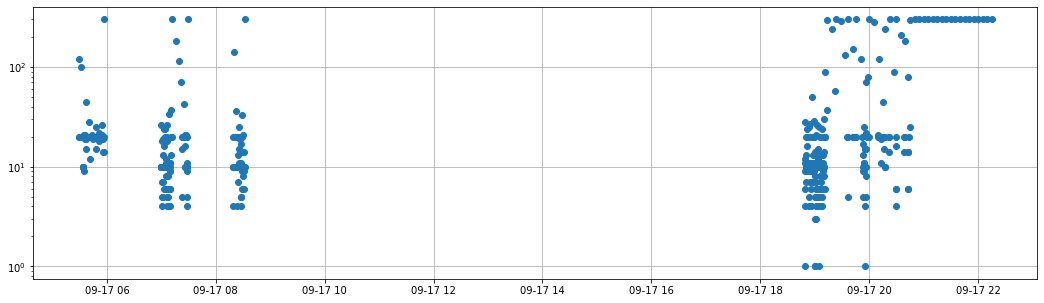

(0.0, 50.0)

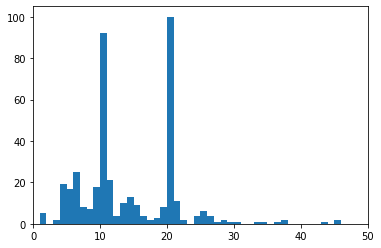

In [105]:
import matplotlib.dates

# from datetime import datetime
plt.figure(figsize=(18, 5))
x_values = dttm[:-1]
y_values = dttm_delta

dates = matplotlib.dates.date2num(x_values)

plt.plot_date(dates, y_values)
plt.yscale("log")
plt.grid()
plt.show()
plt.hist(dttm_delta.astype(int), bins=60*5-1)
plt.xlim([0, 50])

In [101]:
dttm_delta[dttm_delta > 60*5] = 300

In [81]:
dttm_delta

array([   20,    20,   120,    20,   100,    10,    10,    10,    10,
           9,    21,    20,    21,    19,    20,    21,    19,    45,
          15,    20,    20,    20,    20,    20,    20,    20,    20,
          20,    28,    12,    20,    20,    20,    20,    20,    20,
          20,    20,    21,    19,    20,    20,    20,    20,    20,
          20,    20,    20,    20,    25,    15,    20,    20,    20,
          20,    20,    20,    20,    20,    22,    18,    20,    21,
          19,    20,    20,    20,    20,    20,    21,    26,    14,
          19,    20,    20,    20,    14,  3737,    10,    10,    10,
          10,    26,     4,     5,    18,     7,    10,    10,    10,
          10,    10,    13,     7,     5,    19,    16,    24,     6,
          10,    10,    10,    10,    20,    24,     6,    10,    12,
           8,    10,    10,    11,    18,     5,     6,    26,     4,
          20,    10,    10,    10,    11,     5,     8,     6,     4,
          10,     6,

In [154]:
# vehicle_df

In [41]:
vehicle_df[['routeName', 'routeColour']].value_counts()

routeName  routeColour
11         green          461
dtype: int64

In [42]:
import matplotlib as mpl

cm = mpl.cm.get_cmap('jet')
# viridis = mpl.colormaps['viridis'].resampled(8)

In [47]:
trace = vehicle_df[['lat', 'lng']].values

m = folium.Map(
    location=np.mean(trace, axis=0), 
    zoom_start=12, height='50%', width='55%'
    )

plot_coloured_route(trace, m)

m

In [46]:
def rgb_to_hex(r, g, b):
    return f'{r:02x}{g:02x}{b:02x}'


def plot_coloured_route(route, folium_map, color_map=mpl.cm.get_cmap('jet'), bins=10):
    bins = min(bins, len(route))
    
    lspace = np.linspace(0, len(route), num=bins+1, dtype=int)
    
    for i, (lb, rb) in enumerate(zip(lspace[:-1], lspace[1:]) ):
        clr = rgb_to_hex(*tuple(map(lambda x : int(x*255), cm(i/bins) ))[:3])
        folium.PolyLine(
            route[lb:rb+1, :],
            color=f"#{clr}", weight=2,
            opacity=0.8
        ).add_to(folium_map)

In [16]:
# result_list

In [20]:
# df.value_counts()
'id', 'imei', 'name', 'stateCode', 'stateName', 'lat', 'lng', 'speed',
       'orientation', 'gpstime', 'routeId', 'routeName', 'routeColour',
       'inDepo', 'busNumber', 'perevId', 'perevName', 'remark', 'online',
       'idBusTypes'
df.keys()

Index(['id', 'imei', 'name', 'stateCode', 'stateName', 'lat', 'lng', 'speed',
       'orientation', 'gpstime', 'routeId', 'routeName', 'routeColour',
       'inDepo', 'busNumber', 'perevId', 'perevName', 'remark', 'online',
       'idBusTypes'],
      dtype='object')

In [29]:
# df['gpstime'].value_counts()
max(sum_df['gpstime']), min(sum_df['gpstime'])

('2022-09-09 22:59:57', '2022-09-08 19:36:01')

In [31]:
len(sum_df['gpstime'].unique()), len(sum_df['gpstime'])

(49461, 224505)

In [32]:
updata_tm = [datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').timestamp() for dt in sum_df['gpstime'].unique() ]
updata_tm_np = np.array(updata_tm)

In [33]:
max(updata_tm_np[1:] - updata_tm_np[:-1])

15462.0

In [34]:
updata_tm_np[1:] - updata_tm_np[:-1]

array([ 1.1000e+01,  3.0000e+00,  7.0000e+00, ...,  7.0000e+00,
       -2.7304e+04,  1.1349e+04])

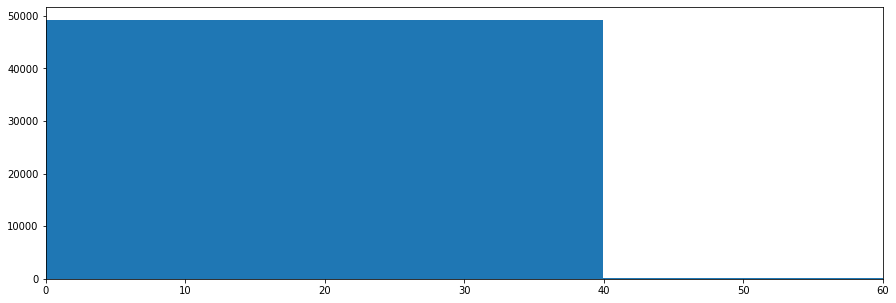

In [35]:
plt.figure(figsize=(15, 5))
plt.hist(updata_tm_np[1:] - updata_tm_np[:-1], bins=391)
plt.xlim(0, 60)
plt.show()

In [36]:
df.keys()

NameError: name 'df' is not defined

In [119]:
d = datetime.now()

In [121]:
d.microsecond > 1_000

343015

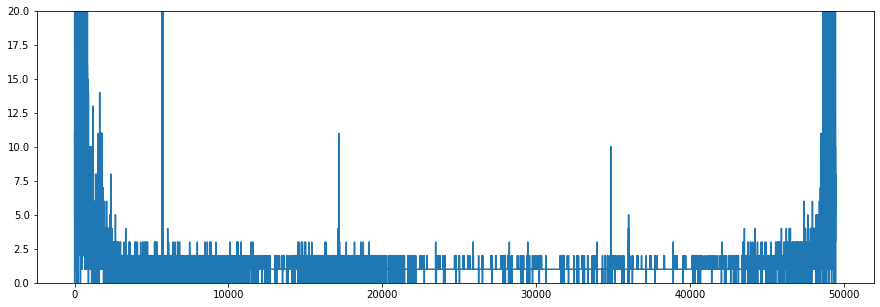

In [37]:
plt.figure(figsize=(15, 5))
plt.plot(updata_tm_np[1:] - updata_tm_np[:-1])
plt.ylim(0, 20)
plt.show()

In [38]:
np.histogram(updata_tm_np[1:] - updata_tm_np[:-1], bins=391)

(array([    1,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

In [ ]:
datetime.strftime('%Y-%m-%d %H;%M;%S')

In [54]:
datetime.strptime('2022-09-05 22:09:58', '%Y-%m-%d %H:%M:%S').timestamp()

1662404998.0

In [35]:
df.iloc[-1]

id                              75
imei               355227045369527
name                            A6
stateCode                     used
stateName                     used
lat                      48.326433
lng                      25.930175
speed                        000.0
orientation                 000.00
gpstime        2022-09-05 22:09:58
routeId                         17
routeName                       23
routeColour                    red
inDepo                       False
busNumber                     3557
perevId                         12
perevName              Vitaliy2019
remark                 3557 DNSNK 
online                        True
idBusTypes                       1
Name: 47737, dtype: object

In [109]:
# for f_path in files_list[:1]:
#     with open(f_path, 'r', encoding = 'utf-8') as file: 
#         response = json.load(file)
        
# for _ in range(5):
#     with open("test_mult_w.json", 'a') as out_f: 
#         json.dump(response, out_f, ensure_ascii=False)
#         out_f.write('\n')

In [41]:
for _ in range(5):
    with open("test_mult_w.json", 'a') as out_f: 
        json.dump(response, out_f, ensure_ascii=False)
        out_f.write('\n')